<a href="https://colab.research.google.com/github/akshaypt7/customer_relationship_prediction/blob/main/Kdd_cup_final_gradientboosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer Relationship Prediction
> Helping businesses to predict churn before its too late

<p><img src="https://cdn.technologyadvice.com/wp-content/uploads/2020/03/6-Ways-CRM-Stop-Customer-Churn-700x408.png" width="1500" height="600"></a><br><a href="https://technologyadvice.com/blog/sales/crm-stop-customer-churn/">Image Source</a></p>

# Introduction

# Data Description

Here we have used the KDD Cup 2009 Dataset from the French Telecom Company Orange, we have used the smaller version of the data set with 230 variables.
Out of these 230 variables we have removed variables which have more than 95% Nan Values and highly correlated variables. The resulting dataset has a total of 60 variables.
The dataset consists of 50,000 records and 3 target variables (Churn, Appetency & Up-selling).

#### Installing and Importing required libraries

In [82]:
import pandas as pd
import numpy as np
from numpy import sqrt
from numpy import argmax
import pickle

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, fbeta_score, f1_score, make_scorer, precision_recall_curve, average_precision_score, roc_curve, auc, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression

import xgboost as xgb

from sklearn.inspection import permutation_importance, plot_partial_dependence, permutation_importance

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import OrdinalEncoder

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import OrdinalEncoder

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import seaborn as sns

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install rfpimp
from rfpimp import plot_corr_heatmap, plot_dependence_heatmap, feature_dependence_matrix, feature_corr_matrix

  Created wheel for rfpimp: filename=rfpimp-1.3.7-cp37-none-any.whl size=10670 sha256=68fa4091b7e836c68fdde274cd415370b1b715a64de384d8156982572c00d609
  Stored in directory: /root/.cache/pip/wheels/16/08/23/9d90df482c9c943df4d6fe874c0937f8e81dc3db917c9300c2
Successfully built rfpimp


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [5]:
!pip install PrettyTable
from prettytable import PrettyTable

In [6]:
f2_score = make_scorer(fbeta_score, beta=2)

### Loading data

In [7]:
df_train = pd.read_csv('/content/drive/MyDrive/UnivAI/ML-2 project/data/orange_small_train.data', sep='\t')

In [8]:
df_train.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,Var11,Var12,Var13,Var14,Var15,Var16,Var17,Var18,Var19,Var20,Var21,Var22,Var23,Var24,Var25,Var26,Var27,Var28,Var29,Var30,Var31,Var32,Var33,Var34,Var35,Var36,Var37,Var38,Var39,Var40,...,Var191,Var192,Var193,Var194,Var195,Var196,Var197,Var198,Var199,Var200,Var201,Var202,Var203,Var204,Var205,Var206,Var207,Var208,Var209,Var210,Var211,Var212,Var213,Var214,Var215,Var216,Var217,Var218,Var219,Var220,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,NaN,NaN,NaN,NaN,NaN,1526.0,7.0,NaN,NaN,NaN,NaN,NaN,184.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,464.0,580.0,NaN,14.0,128.0,NaN,NaN,166.56,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,3570.0,NaN,NaN,...,NaN,bZkvyxLkBI,RO12,NaN,taul,1K8T,lK27,ka_ns41,nQUveAzAF7,NaN,NaN,dXGu,9_Y1,FbIm,VpdQ,haYg,me75fM6ugJ,kIsH,NaN,uKAI,L84s,XfqtO3UdzaXh_,NaN,NaN,NaN,XTbPUYD,sH5Z,cJvF,FzaX,1YVfGrO,oslk,fXVEsaq,jySVZNlOJy,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,525.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,168.0,210.0,NaN,2.0,24.0,NaN,NaN,353.52,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,4764966.0,NaN,NaN,...,NaN,CEat0G8rTN,RO12,NaN,taul,1K8T,2Ix5,qEdASpP,y2LIM01bE1,NaN,NaN,lg1t,9_Y1,k13i,sJzTlal,zm5i,me75fM6ugJ,kIsH,NaN,uKAI,L84s,NhsEn4L,NaN,NaN,NaN,kZJyVg2,NaN,NaN,FzaX,0AJo2f2,oslk,2Kb5FSF,LM8l689qOp,NaN,NaN,fKCe,RAYp,F2FyR07IdsN7I,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,5236.0,7.0,NaN,NaN,NaN,NaN,NaN,904.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1212.0,1515.0,NaN,26.0,816.0,NaN,NaN,220.08,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,5883894.0,NaN,NaN,...,NaN,eOQt0GoOh3,AERks4l,SEuy,taul,1K8T,ffXs,NldASpP,y4g9XoZ,vynJTq9,smXZ,4bTR,9_Y1,MGOA,VpdQ,haYg,DHn_WUyBhW_whjA88g9bvA64_,kIsH,NaN,uKAI,L84s,UbxQ8lZ,NaN,TTGHfSv,NaN,pMWAe2U,bHR7,UYBR,FzaX,JFM1BiF,Al6ZaUT,NKv4yOc,jySVZNlOJy,NaN,kG3k,Qu4f,02N6s8f,ib5G6X1eUxUn6,am7c,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,22.08,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,...,NaN,jg69tYsGvO,RO12,NaN,taul,1K8T,ssAy,_ybO0dd,4hMlgkf58mhwh,NaN,NaN,W8mQ,9_Y1,YULl,VpdQ,NaN,me75fM6ugJ,kIsH,NaN,uKAI,Mtgm,NhsEn4L,NaN,NaN,NaN,kq0dQfu,eKej,UYBR,FzaX,L91KIiz,oslk,CE7uk3u,LM8l689qOp,NaN,NaN,FSa2,RAYp,F2FyR07IdsN7I,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,1029.0,7.0,NaN,NaN,NaN,NaN,NaN,3216.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.0,80.0,NaN,4.0,64.0,NaN,NaN,200.00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,...,NaN,IXSgUHShse,RO12,SEuy,taul,1K8T,uNkU,EKR938I,ThrHXVS,0v21jmy,smXZ,xklU,9_Y1,RVjC,sJzTlal,6JmL,me75fM6ugJ,kIsH,NaN,uKAI,L84s,XfqtO3UdzaXh_,NaN,SJs3duv,NaN,11p4mKe,H3p7,UYBR,FzaX,OrnLfvc,oslk,1J2cvxe,LM8l689qOp,NaN,kG3k,FSa2,RAYp,F2FyR07IdsN7I,mj86,NaN


In [9]:
y_train_churn = pd.read_table('/content/drive/MyDrive/UnivAI/ML-2 project/data/orange_small_train_churn.labels', header = None).loc[:, 0].astype('category')
y_train_churn.head()

0   -1
1    1
2   -1
3   -1
4   -1
Name: 0, dtype: category
Categories (2, int64): [-1, 1]

In [10]:
y_train_appetency =pd.read_table('/content/drive/MyDrive/UnivAI/ML-2 project/data/orange_small_train_appetency.labels',header = None).loc[:, 0].astype('category')
y_train_appetency.head()

0   -1
1   -1
2   -1
3   -1
4   -1
Name: 0, dtype: category
Categories (2, int64): [-1, 1]

In [11]:
y_train_upselling= pd.read_table('/content/drive/MyDrive/UnivAI/ML-2 project/data/orange_small_train_upselling.labels', header = None).loc[:, 0].astype('category')
y_train_upselling.head()

0   -1
1   -1
2   -1
3   -1
4   -1
Name: 0, dtype: category
Categories (2, int64): [-1, 1]

In [12]:
df_test = pd.read_table('/content/drive/MyDrive/UnivAI/ML-2 project/data/orange_small_test.data')
df_test.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,Var11,Var12,Var13,Var14,Var15,Var16,Var17,Var18,Var19,Var20,Var21,Var22,Var23,Var24,Var25,Var26,Var27,Var28,Var29,Var30,Var31,Var32,Var33,Var34,Var35,Var36,Var37,Var38,Var39,Var40,...,Var191,Var192,Var193,Var194,Var195,Var196,Var197,Var198,Var199,Var200,Var201,Var202,Var203,Var204,Var205,Var206,Var207,Var208,Var209,Var210,Var211,Var212,Var213,Var214,Var215,Var216,Var217,Var218,Var219,Var220,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,NaN,NaN,NaN,NaN,NaN,1225.0,7.0,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,156.0,195.0,NaN,0.0,72.0,NaN,NaN,166.56,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,4259232.0,NaN,NaN,...,NaN,xddq9ayfAo,RO12,NaN,taul,1K8T,PShj,iJzviRg,17VONbZnAuZ90atz,MF5EBmj,NaN,WVvO,9_Y1,vm5R,VpdQ,haYg,7M47J5GA0pTYIFxg5uy,kIsH,NaN,uKAI,L84s,H4p93_uThXwSG,NaN,XREFJCi,NaN,7WwzJJY,OgPm,cJvF,FzaX,ch2oGfM,Al6ZaUT,P6pu4Vl,LM8l689qOp,NaN,ELof,7P5s,ZI9m,R4y5gQQWY8OodqDV,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,259.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,240.0,NaN,0.0,40.0,NaN,NaN,300.32,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,4859550.0,NaN,NaN,...,NaN,cFHt0GoOh3,RO12,NaN,taul,1K8T,lK27,rsmctTK,7ONkRNQCK7,NaN,NaN,aFB2,9_Y1,t_4G,VpdQ,zm5i,me75fM6ugJ,kIsH,NaN,uKAI,L84s,NhsEn4L,NaN,NaN,NaN,kZJyVg2,4ls8,cJvF,FzaX,Kgofc8E,oslk,S46Rt72,LM8l689qOp,NaN,NaN,Qu4f,RAYp,F2FyR07IdsN7I,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,861.0,14.0,NaN,NaN,NaN,NaN,NaN,236.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,40.0,NaN,0.0,8.0,NaN,NaN,186.64,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,10038840.0,NaN,NaN,...,NaN,zcROj17IEC,RO12,NaN,taul,1K8T,oXaB,I6Bd3iM,bGUqwlz,NaN,NaN,6k5I,9_Y1,iVbl,VpdQ,zm5i,me75fM6ugJ,kIsH,NaN,uKAI,L84s,NhsEn4L,NaN,NaN,NaN,kZJtVhC,0b0w,cJvF,FzaX,bBmOw16,oslk,CcdTy9x,LM8l689qOp,NaN,NaN,7aLG,RAYp,F2FyR07IdsN7I,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,1568.0,7.0,NaN,NaN,NaN,NaN,NaN,1232.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,448.0,560.0,NaN,4.0,88.0,NaN,NaN,166.56,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,116760.0,NaN,NaN,...,NaN,gOyq9ayE15,2Knk1KF,SEuy,taul,1K8T,tzKK,Te2s8CN,hOpRIhsUSP,x0xpMjN,smXZ,kVZt,9_Y1,vm5R,VpdQ,6JmL,me75fM6ugJ,kIsH,NaN,uKAI,L84s,XfqtO3UdzaXh_,NaN,3yoa8Yv,NaN,XTbPUYD,XqfQ,UYBR,AU8pNoi,rDm6pd1,oslk,Q53Rkup,LM8l689qOp,NaN,kG3k,7P5s,RAYp,TCU50_Yjmm6GIBZ0lL_,am7c,NaN
4,NaN,NaN,NaN,NaN,NaN,1197.0,7.0,NaN,NaN,NaN,NaN,NaN,204.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,125.0,NaN,8.0,40.0,NaN,NaN,133.12,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,257772.0,NaN,NaN,...,NaN,voArjIXt5a,onTuEhrJJQy_H3IHkZku5AFczhYGqxJ890,NaN,taul,1K8T,80HR,fqeOwLG,nJy8d8N5V7yiy,IBmPo7a,NaN,oyu5,9_Y1,WIr3,VpdQ,kxE9,7M47J5GA0pTYIFxg5uy,kIsH,NaN,uKAI,L84s,H4p93_uThXwSG,NaN,c02HCHI,NaN,_JdEa95,bOvW,cJvF,FzaX,fxJmel6,Al6ZaUT,WfsWw2A,LM8l689qOp,NaN,ELof,5Acm,ZI9m,iyHGyLCEkQ,am7c,NaN


**Change the lables from [-1, 1] to [0, 1]**

In [13]:
y_train_appetency = (y_train_appetency.astype('int') + 1)/2
y_train_churn = (y_train_churn.astype('int') + 1)/2
y_train_upselling = (y_train_upselling.astype('int') + 1)/2

In [14]:
y_train_appetency.tail()

49995    1.0
49996    1.0
49997    0.0
49998    0.0
49999    0.0
Name: 0, dtype: float64

# EDA and preprocessing

In [15]:
np.mean(y_train_appetency == 1) , np.mean(y_train_churn == 1) , np.mean(y_train_upselling == 1)

(0.0178, 0.07344, 0.07364)

In [16]:
y_train_churn.value_counts()

0.0    46328
1.0     3672
Name: 0, dtype: int64

In [17]:
y_train_appetency.value_counts()

0.0    49110
1.0      890
Name: 0, dtype: int64

In [18]:
y_train_upselling.value_counts()

0.0    46318
1.0     3682
Name: 0, dtype: int64

### Visualizing imbalance

From above we can clearly see that the data is highly imbalanced, where the percentage of churn and upselling are as low as 7% and appetency is even lower with just 1%

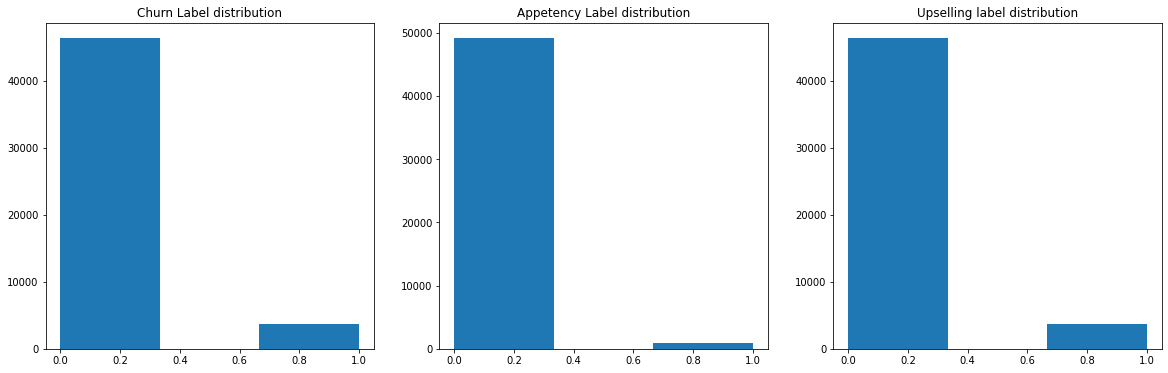

In [19]:
fig, axes = plt.subplots(1,3, figsize=(20,6))
axes[0].hist(y_train_churn, bins=3)
axes[0].set_title('Churn Label distribution')
axes[1].hist(y_train_appetency, bins=3)
axes[1].set_title('Appetency Label distribution')
axes[2].hist(y_train_upselling, bins=3)
axes[2].set_title('Upselling label distribution')
plt.show()

### Table report

Lets now understand more about each column i.e. dtypes, number of null values, total unique values and count of differnt column values. This will help us get more insights on the data and catch the anamoly well in advance.

In [20]:
def pretty_print(df):
    return display( HTML( df.to_html().replace("\\n","<br>") ) )

In [21]:
def tbl_report(tbl, cols=None, card=10):
    print("Table Shape", tbl.shape)
    dtypes = tbl.dtypes
    nulls = []
    uniques = []
    numuniques = []
    vcs = []
    for col in dtypes.index:
        n = tbl[col].isnull().sum()
        nulls.append(n)
        strdtcol = str(dtypes[col])
        #if strdtcol == 'object' or strdtcol[0:3] == 'int' or strdtcol[0:3] == 'int':
        #print(strdtcol)
        uniqs = tbl[col].unique()
        uniquenums = uniqs.shape[0]
        if uniquenums < card: # low cardinality
            valcounts = pd.value_counts(tbl[col], dropna=False)
            vc = "\n".join(["{}:{}".format(k,v) for k, v in valcounts.items()])
        else:
            vc='HC' # high cardinality
        uniques.append(uniqs)
        numuniques.append(uniquenums)
        vcs.append(vc)
    nullseries = pd.Series(nulls, index=dtypes.index)
    uniqueseries = pd.Series(uniques, index=dtypes.index)
    numuniqueseries = pd.Series(numuniques, index=dtypes.index)
    vcseries = pd.Series(vcs, index=dtypes.index)
    df = pd.concat([dtypes, nullseries, uniqueseries, numuniqueseries, vcseries], axis=1)
    df.columns = ['dtype', 'nulls', 'uniques', 'num_uniques', 'value_counts']
    if cols:
        return df[cols]
    return df


In [22]:
pretty_print(tbl_report(df_train, cols=['dtype', 'nulls', 'num_uniques', 'value_counts']))

Table Shape (50000, 230)


,dtype,nulls,num_uniques,value_counts
Var1,float64,49298,19,HC
Var2,float64,48759,3,nan:487590.0:12405.0:1
Var3,float64,48760,147,HC
Var4,float64,48421,5,nan:484210.0:15619.0:1518.0:227.0:1
Var5,float64,48513,572,HC
Var6,float64,5529,1487,HC
Var7,float64,5539,9,7.0:235300.0:13090nan:553914.0:504921.0:182528.0:70335.0:262140.0:142.0:1
Var8,float64,50000,1,nan:50000
Var9,float64,49298,101,HC
Var10,float64,48513,535,HC


### Null handling

From the above we can clearly see that many columns in our data have exteemly high null values, lets understand the scale of null values better via visualization.

Table Shape (50000, 230)


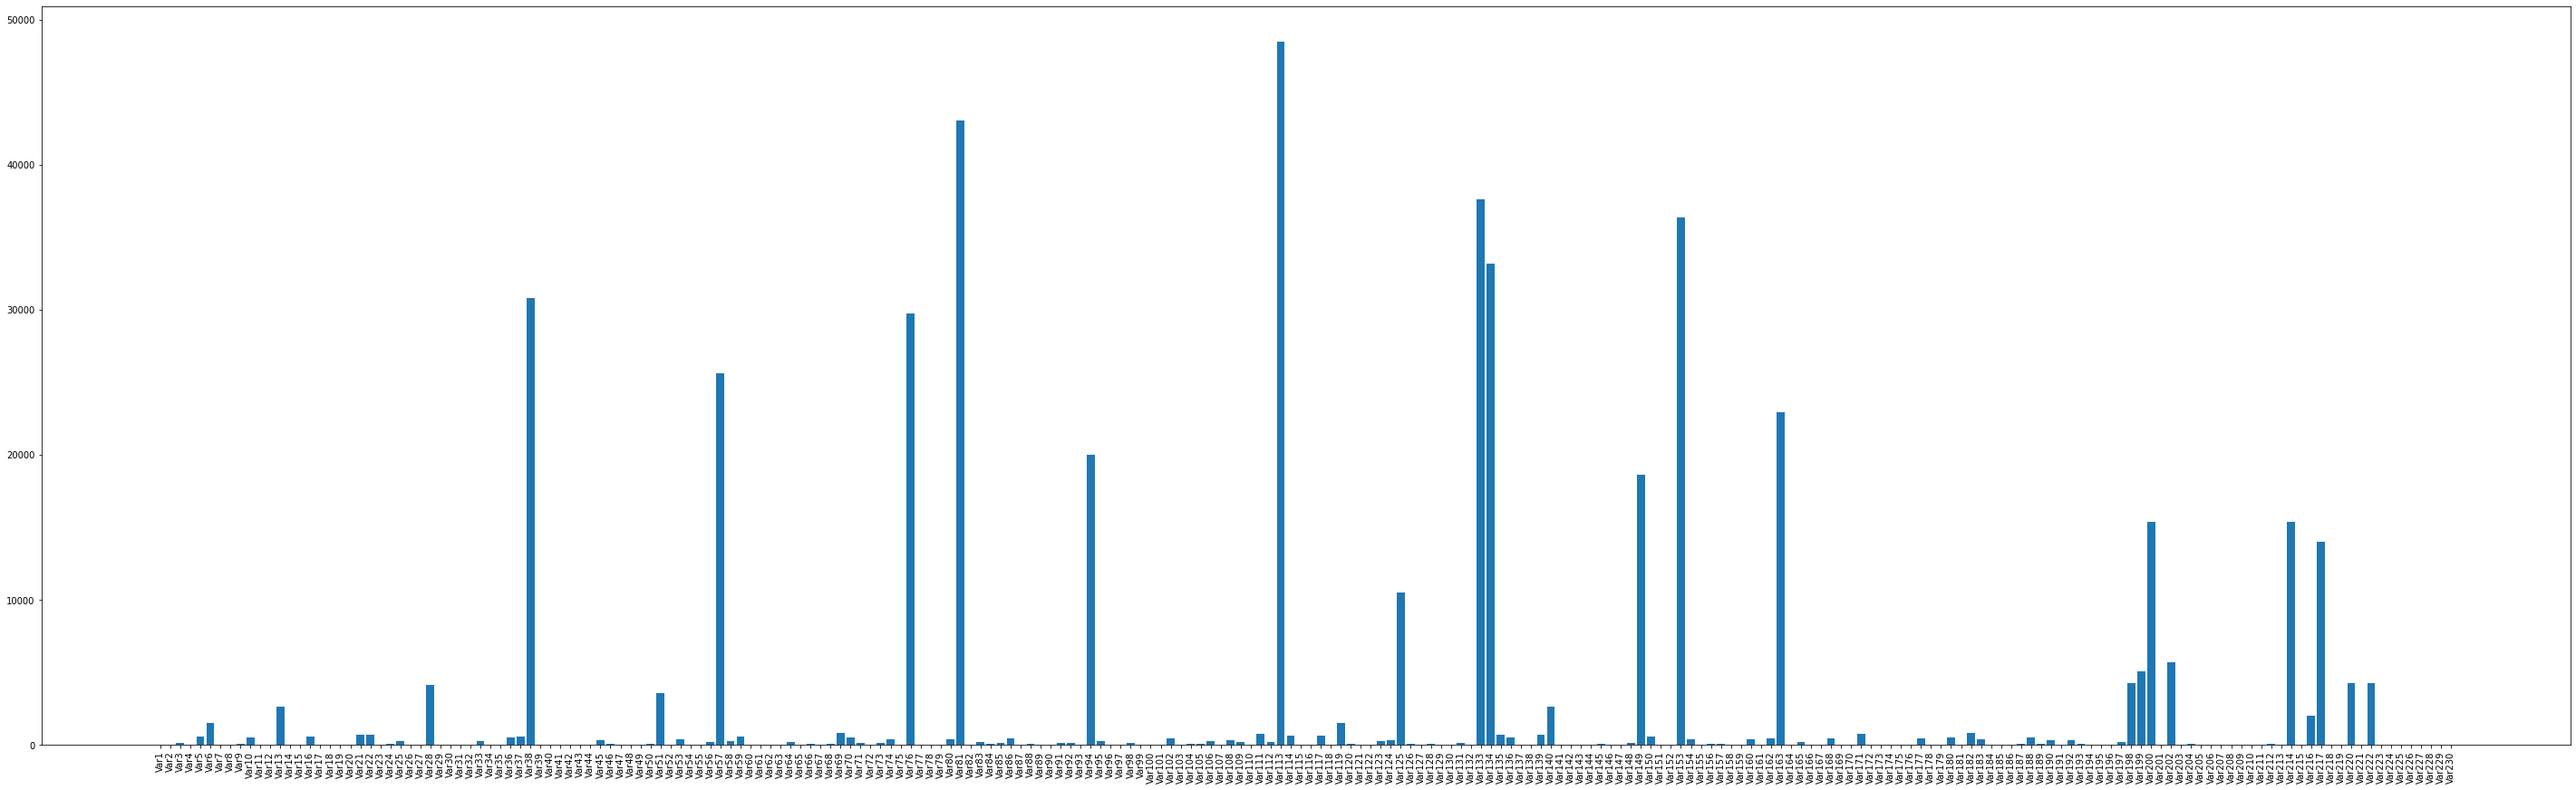

In [23]:
table_report = tbl_report(df_train, cols=['dtype', 'nulls', 'num_uniques', 'value_counts'])

plt.figure(figsize=(50,15))
plt.bar(table_report.index, table_report['num_uniques'])
plt.xticks(rotation=90, fontsize=10)
plt.show()

In [24]:
df_table = tbl_report(df_train, cols=['dtype', 'nulls', 'num_uniques', 'value_counts']) # Using the second tbl_report function

df_table['dtype'].value_counts()

Table Shape (50000, 230)


float64    191
object      38
int64        1
Name: dtype, dtype: int64

In [25]:
df_float = df_table[df_table['dtype']== 'float64']
lst_empty_float_cols = list(df_float[df_float['nulls'] > len(df_train)*0.95 ].index)
print("Number of float cols where more than 95% of data is null = ",len(lst_empty_float_cols))

Number of float cols where more than 95% of data is null =  149


In [26]:
df_object = df_table[df_table['dtype']== 'object']
lst_empty_categorical_cols = list(df_object[df_object['nulls'] > len(df_train)*0.95 ].index)
print("Number of categorical cols where more than 95% of data is null = ",len(lst_empty_categorical_cols))

Number of categorical cols where more than 95% of data is null =  4


In [27]:
drop_cols = lst_empty_float_cols + lst_empty_categorical_cols
print("Total columns to be dropped =",len(drop_cols))

Total columns to be dropped = 153


# Data preprocessing

**Now lets drop the columns where more than 95% of the data is null**



In [28]:
df_train_kdd = df_train.drop(drop_cols,axis=1)

In [29]:
categorical_cols = list(df_train_kdd.dtypes[df_train_kdd.dtypes == 'object'].index)
continuous_cols = list(df_train_kdd.dtypes[(df_train_kdd.dtypes == 'float64') | (df_train_kdd.dtypes == 'int64')].index)

Out of the remaining categorical columns, replace the null values with 'o', such that when we ordinal encode it further, all the null values would get a separate encoding.

In [30]:
df_train_cat_cols = df_train_kdd[categorical_cols].fillna('o')

### Ordinal encoding of categorical variables

Here we've ordinal encoded it before train-val split because otherwise there were a few categories in val set which weren't seen in train set. Although we could have have set `handle_unknown:use_encoded_value`, we did not want all the unseen values to get one value only.

In [31]:
encoder = OrdinalEncoder()
# transform data
encoder.fit(df_train_cat_cols)
encoded_train_cat_cols = encoder.transform(df_train_cat_cols)

In [32]:
df_train_kdd[categorical_cols] = pd.DataFrame(encoded_train_cat_cols, columns=categorical_cols)

### Histogram plot

Here we can see that many columns have outliers, this would highly degrade the performance of gradient boosting algorithim, since it fits the model on the gradient of the residuls. Therefore we are standard scaling the data.

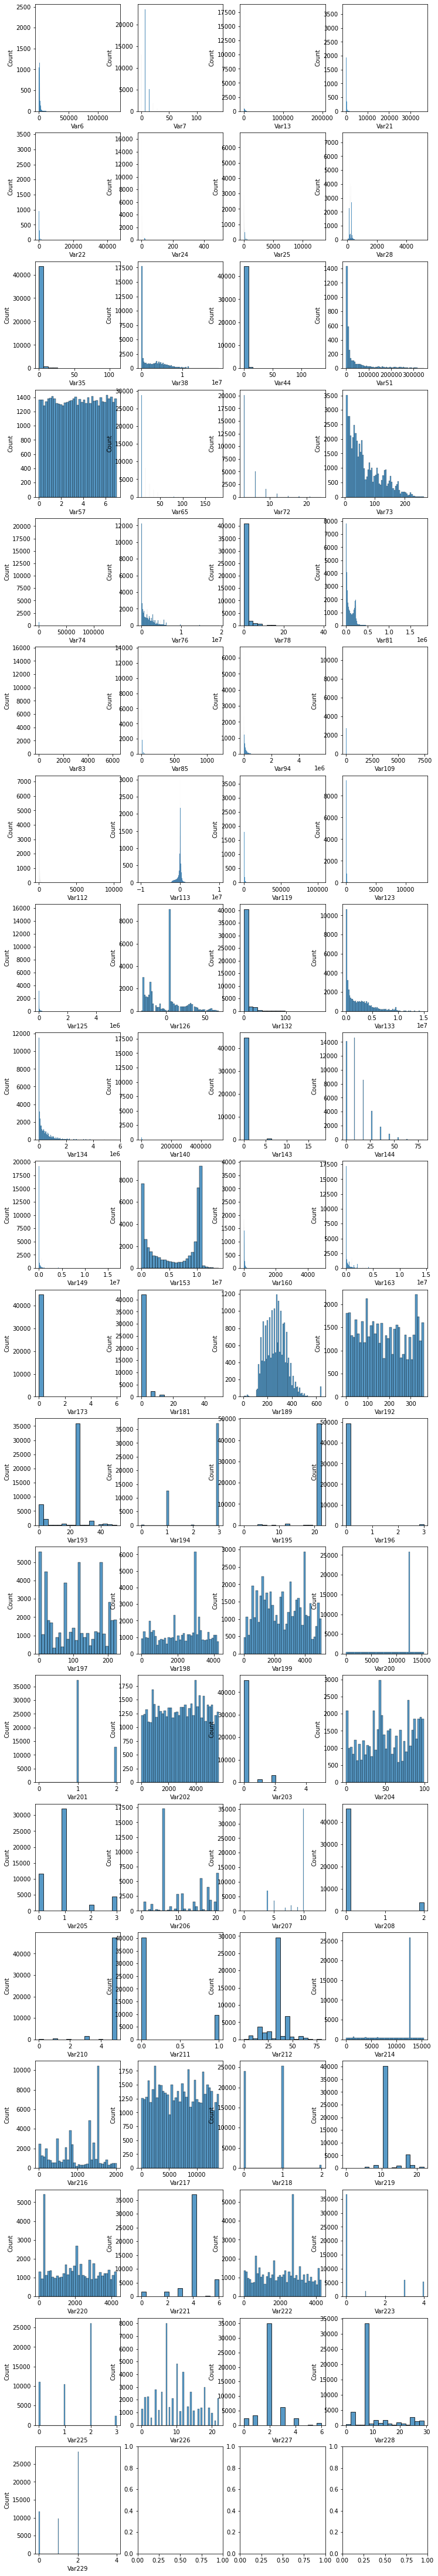

In [31]:
import math
ncols = 4
nrows = math.ceil(len(df_train_kdd.columns)/ncols)
fig, axen = plt.subplots(nrows, ncols, figsize = (12, nrows*4))
for v, ax in zip(df_train_kdd.columns, axen.ravel()):
    sns.histplot(df_train_kdd[v], ax=ax)

### Train-Val split

**Kindly note:**

Here we've performed training-validation split because we realized that OOB error can be misleading when we're dealing with highly imbalanced data. The reason being that, in this case OOB set will most of the time end up having the highest class value, so even though the oob error is quite low, it's f2 score is extremely low (0.008). 

You can see the different oob error comparisions and how we arrived at the conclusion in [this notebook](https://colab.research.google.com/github/akshaypt7/customer_relationship_prediction/blob/main/KDD_cup_ada_boosting.ipynb#scrollTo=Ie4KlBKoaulq)

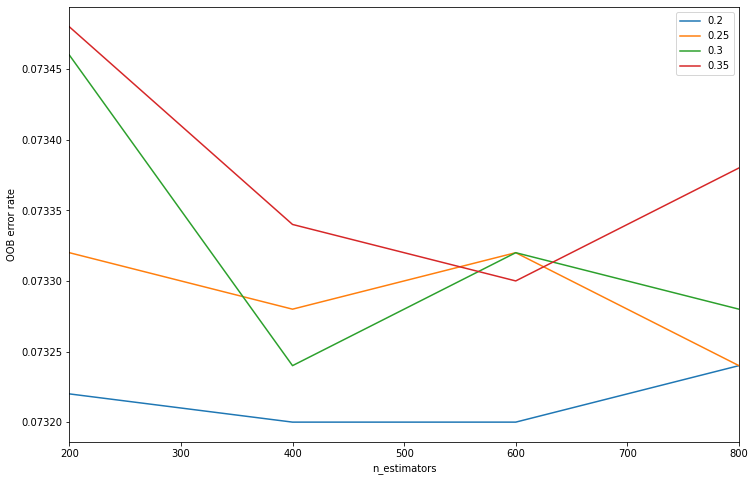

In [33]:
X_train, X_val, y_train, y_val = train_test_split(df_train_kdd, y_train_churn, random_state=66, train_size=0.8, stratify=y_train_churn)
X_train_upselling, X_val_upselling, y_train_upselling, y_val_upselling = train_test_split(df_train_kdd, y_train_upselling, random_state=66, train_size=0.8, stratify=y_train_upselling)
X_train_appetency, X_val_appetency, y_train_appetency, y_val_appetency = train_test_split(df_train_kdd, y_train_appetency, random_state=66, train_size=0.8, stratify=y_train_appetency)

Replacing the nan values in continuous colums with the mean of the respective colums.

In [34]:
X_train = X_train.fillna(X_train.mean())
X_val = X_val.fillna(X_train.mean())

X_train_upselling = X_train_upselling.fillna(X_train_upselling.mean())
X_val_upselling = X_val_upselling.fillna(X_train_upselling.mean())

X_train_appetency = X_train_appetency.fillna(X_train_appetency.mean())
X_val_appetency = X_val_appetency.fillna(X_train_appetency.mean())


### Random upsampling + downsampling

Here we did not want to just include upsampling which would make the model overfit on that class, or just downsample the data which would lead to loss of valuable information. Therefore we're combining both upsampling of minority class and downsampling of majority class to achive the balance in data.

In [35]:
def upsample_downsample(X, y):
    # define oversampling strategy
    over_sample = RandomOverSampler(sampling_strategy=0.2)
    X_over, y_over = over_sample.fit_resample(X, y)

    # define under sampling strategy
    under_sample = RandomUnderSampler(sampling_strategy=0.5)
    X_balanced, y_balanced = under_sample.fit_resample(X_over, y_over)
    return X_balanced, y_balanced

In [36]:
X_train.head()

,Var6,Var7,Var13,Var21,Var22,Var24,Var25,Var28,Var35,Var38,Var44,Var51,Var57,Var65,Var72,Var73,Var74,Var76,Var78,Var81,Var83,Var85,Var94,Var109,Var112,Var113,Var119,Var123,Var125,Var126,Var132,Var133,Var134,Var140,Var143,Var144,Var149,Var153,Var160,Var163,Var173,Var181,Var189,Var192,Var193,Var194,Var195,Var196,Var197,Var198,Var199,Var200,Var201,Var202,Var203,Var204,Var205,Var206,Var207,Var208,Var210,Var211,Var212,Var214,Var216,Var217,Var218,Var219,Var220,Var221,Var222,Var223,Var225,Var226,Var227,Var228,Var229
35505,343.0,7.0,1488.0,84.0,105.0,2.0,128.0,200.00,0.0,0.0,0.0,42536.253515,5.836574,9.0,4.187324,92,0.0,7904.0,0.0,3694.35,0.0,4.0,99161.216747,16.0,8.0,3364.716,290.0,0.0,2430.0,68.000000,0.0,6995.0,43974.0,1435.0,0.0,9.0,2324.0,102112.0,4.0,6924.0,0.0,0.0,336.000000,209.0,25.0,3.0,22.0,0.0,177.0,3216.0,1291.0,9964.0,1.0,5545.0,0.0,35.0,1.0,18.0,10.0,0.0,5.0,0.0,33.0,685.0,1418.0,4752.0,1.0,11.0,2246.0,4.0,3910.0,0.0,0.0,1.0,2.0,8.0,0.0
28064,1442.0,7.0,792.0,172.0,215.0,6.0,64.0,286.96,0.0,5789556.0,0.0,42536.253515,2.024354,9.0,4.187324,56,168.0,2550296.0,0.0,138998.40,10.0,18.0,99161.216747,88.0,48.0,94877.200,905.0,78.0,92817.0,-30.000000,0.0,1980105.0,1109132.0,635.0,0.0,18.0,1309861.0,10533160.0,10.0,1443474.0,0.0,0.0,270.523569,95.0,25.0,1.0,22.0,0.0,222.0,461.0,1073.0,1938.0,2.0,5134.0,0.0,41.0,1.0,10.0,10.0,0.0,5.0,0.0,44.0,14591.0,6.0,1355.0,1.0,11.0,4059.0,4.0,840.0,3.0,3.0,4.0,2.0,8.0,0.0
27185,1946.0,0.0,0.0,296.0,370.0,2.0,56.0,200.00,0.0,7820820.0,0.0,42536.253515,0.021363,9.0,4.187324,78,0.0,983160.0,0.0,82460.09,40.0,4.0,99161.216747,56.0,72.0,71299.200,1960.0,120.0,7740.0,-0.528886,0.0,1287575.0,532514.0,0.0,0.0,0.0,152208.0,10436720.0,56.0,449868.0,0.0,0.0,138.000000,95.0,25.0,1.0,22.0,0.0,207.0,2641.0,750.0,10135.0,2.0,1940.0,0.0,0.0,0.0,6.0,10.0,0.0,5.0,0.0,33.0,5712.0,1544.0,4598.0,0.0,11.0,3823.0,4.0,2385.0,1.0,1.0,4.0,2.0,8.0,1.0
42938,336.0,7.0,16.0,76.0,95.0,2.0,32.0,200.00,0.0,19914.0,0.0,42536.253515,4.088016,9.0,4.187324,116,0.0,19112.0,0.0,6333.84,0.0,0.0,99161.216747,16.0,16.0,-10617.000,385.0,6.0,5265.0,42.000000,0.0,123910.0,59742.0,25.0,0.0,9.0,1050.0,241444.0,24.0,0.0,0.0,0.0,270.523569,330.0,0.0,1.0,22.0,0.0,217.0,1531.0,3246.0,3100.0,2.0,5022.0,0.0,6.0,0.0,3.0,5.0,0.0,5.0,0.0,18.0,9941.0,212.0,4381.0,0.0,11.0,232.0,3.0,4242.0,0.0,1.0,10.0,4.0,2.0,0.0
7183,203.0,0.0,0.0,20.0,25.0,0.0,16.0,230.56,0.0,881166.0,0.0,42536.253515,3.230506,27.0,9.000000,22,0.0,0.0,0.0,190752.30,0.0,0.0,405183.000000,0.0,0.0,-111240.800,215.0,6.0,0.0,-2.000000,0.0,3490395.0,2388380.0,0.0,0.0,9.0,0.0,8156520.0,4.0,0.0,0.0,0.0,270.523569,135.0,25.0,3.0,22.0,0.0,64.0,1844.0,1191.0,12515.0,1.0,5610.0,0.0,36.0,1.0,21.0,10.0,0.0,5.0,1.0,33.0,12581.0,180.0,5862.0,0.0,11.0,2502.0,4.0,2859.0,0.0,2.0,12.0,2.0,8.0,2.0


In [37]:
X_balanced, y_balanced = upsample_downsample(X_train, y_train)
X_balanced_upselling, y_balanced_upselling = upsample_downsample(X_train_upselling, y_train_upselling)
X_balanced_appetency, y_balanced_appetency = upsample_downsample(X_train_appetency, y_train_appetency)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

In [38]:
X_balanced = pd.DataFrame(X_balanced,columns=X_train.columns)
X_balanced_upselling = pd.DataFrame(X_balanced_upselling,columns=X_train_upselling.columns)
X_balanced_appetency = pd.DataFrame(X_balanced_appetency,columns=X_train_appetency.columns)


In [39]:
cont_cols_df_X = X_balanced[continuous_cols]
cont_cols_df_upselling_X = X_balanced_upselling[continuous_cols]
cont_cols_df_appetency_X = X_balanced_appetency[continuous_cols]


Distribution of positive and negative class after random upsampling+downsampling

In [40]:
np.unique(y_balanced, return_counts=True)

(array([0., 1.]), array([14824,  7412]))

In [41]:
np.unique(y_balanced_upselling, return_counts=True)

(array([0., 1.]), array([14820,  7410]))

In [42]:
np.unique(y_balanced_appetency, return_counts=True)

(array([0., 1.]), array([15714,  7857]))

### Standard Scaler

Here we are scaling the continuous data inorder to achive good performace on the boosting algorithms.

In [43]:
scaler = StandardScaler()
scaler.fit(cont_cols_df_X)
scaled_X_balanced = scaler.transform(cont_cols_df_X)

In [44]:
scaler_upselling = StandardScaler()
scaler_upselling.fit(cont_cols_df_upselling_X)
scaled_X_balanced_upselling = scaler_upselling.transform(cont_cols_df_upselling_X)

In [45]:
scaler_appetency = StandardScaler()
scaler_appetency.fit(cont_cols_df_appetency_X)
scaled_X_balanced_appetency = scaler_appetency.transform(cont_cols_df_appetency_X)

In [46]:
X_balanced_scaled = pd.DataFrame(scaled_X_balanced,columns=continuous_cols).join(X_balanced[categorical_cols])
X_balanced_scaled.columns = X_balanced.columns

X_balanced_scaled_upselling = pd.DataFrame(scaled_X_balanced_upselling,columns=continuous_cols).join(X_balanced_upselling[categorical_cols])
X_balanced_scaled_upselling.columns = X_balanced_upselling.columns

X_balanced_scaled_appetency = pd.DataFrame(scaled_X_balanced_appetency,columns=continuous_cols).join(X_balanced_appetency[categorical_cols])
X_balanced_scaled_appetency.columns = X_balanced_appetency.columns

In [47]:
X_val = X_val.reset_index().drop('index', axis=1)
X_val_upselling = X_val_upselling.reset_index().drop('index', axis=1)
X_val_appetency = X_val_appetency.reset_index().drop('index', axis=1)


In [48]:
X_val_scaled = pd.DataFrame(scaler.transform(X_val[continuous_cols])).join(X_val[categorical_cols])
X_val_scaled.columns = X_balanced.columns

X_val_scaled_upselling = pd.DataFrame(scaler_upselling.transform(X_val_upselling[continuous_cols])).join(X_val_upselling[categorical_cols])
X_val_scaled_upselling.columns = X_balanced_upselling.columns

X_val_scaled_appetency = pd.DataFrame(scaler_appetency.transform(X_val_appetency[continuous_cols])).join(X_val_appetency[categorical_cols])
X_val_scaled_appetency.columns = X_balanced_appetency.columns

### Correlation plot

Here we're checking the correlation among the predictors and droping one of the column where the correlation > 0.7

#### Correlation plot for Churn data

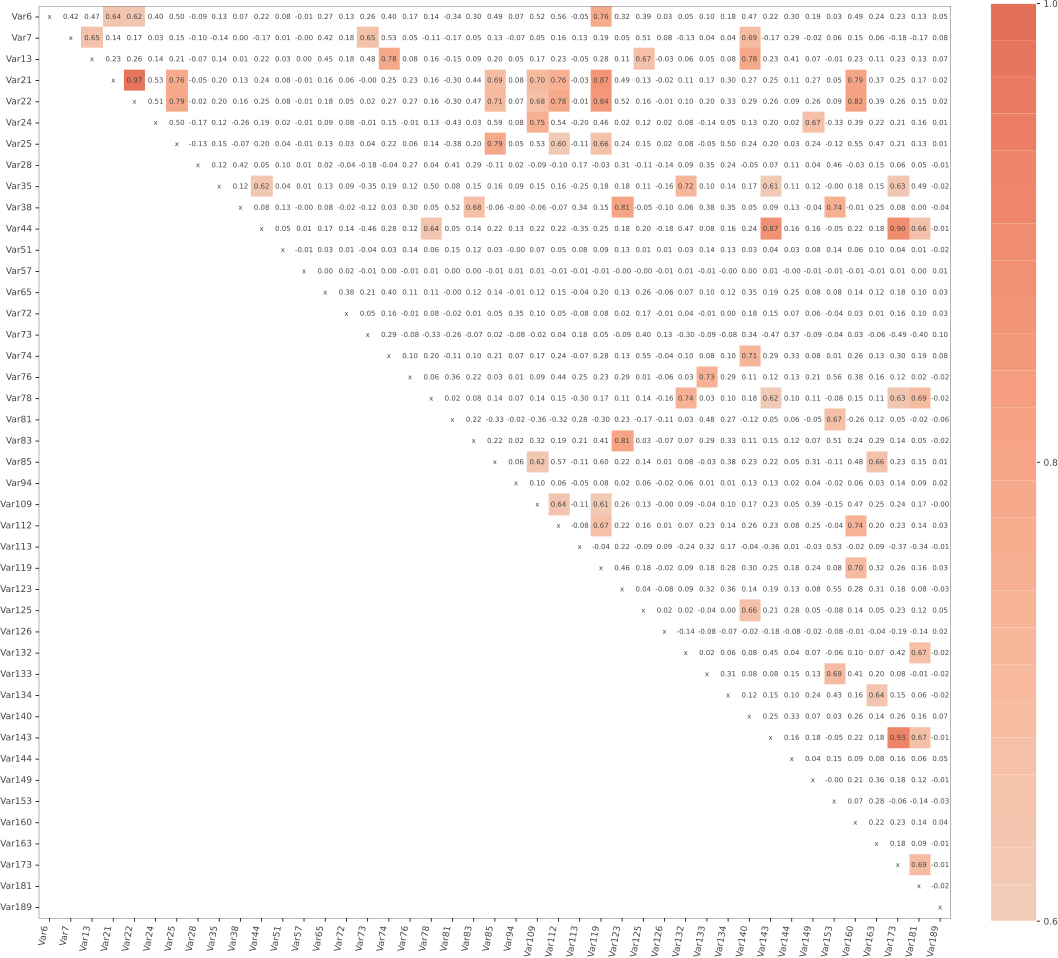

In [49]:
viz = plot_corr_heatmap(X_balanced_scaled[continuous_cols], figsize=(15,15), label_fontsize=9, value_fontsize=7)
viz

In [49]:
corr_matrix = feature_corr_matrix(X_balanced_scaled).abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.70
to_drop = [column for column in upper.columns if any(upper[column] > 0.70)]

# Drop features 
print("Total columns to drop due to high correlation=",len(to_drop))

Total columns to drop due to high correlation= 17


In [50]:
X_balanced_scaled.drop(to_drop, axis=1, inplace=True)
X_val_scaled.drop(to_drop, axis=1, inplace=True)

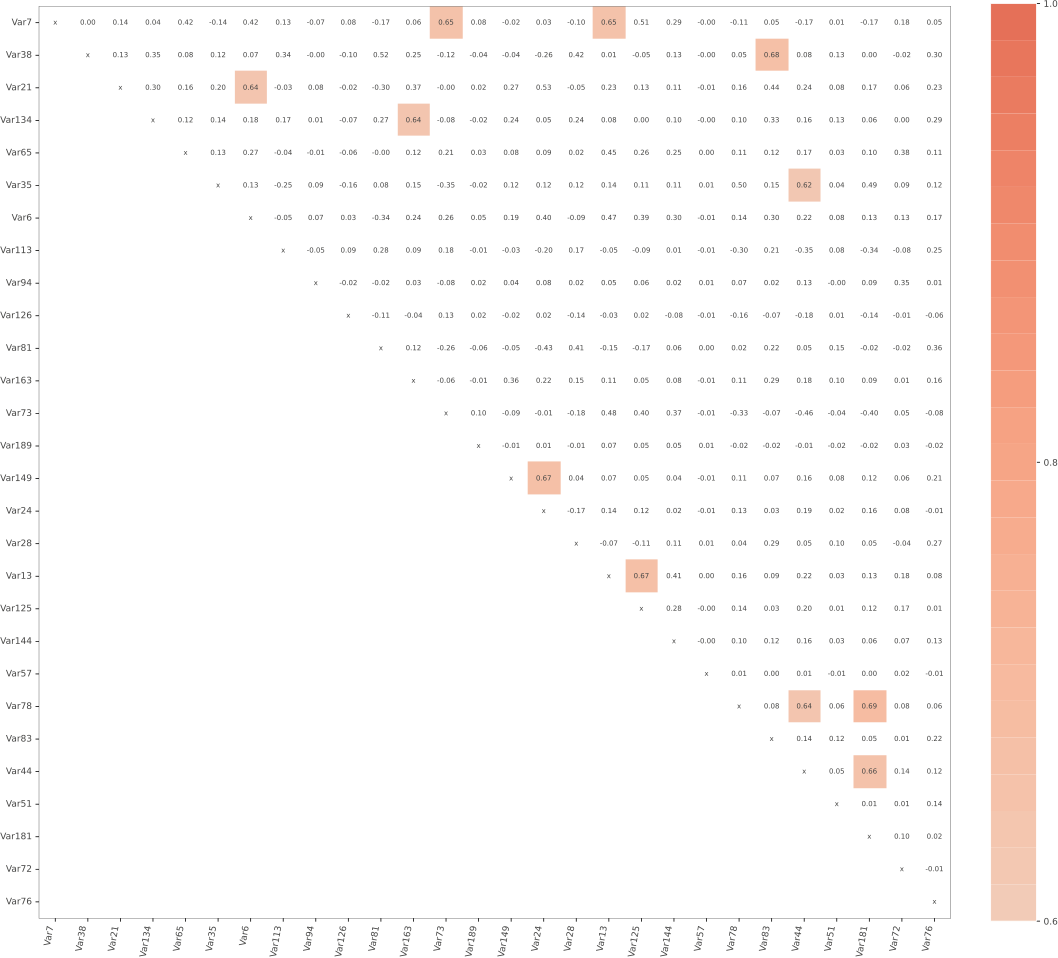

In [52]:
viz = plot_corr_heatmap(X_balanced_scaled[set(continuous_cols) - set(to_drop)], figsize=(15,15), label_fontsize=9, value_fontsize=7)
viz

#### Correlation plot for Upselling

In [51]:
corr_matrix_upselling = feature_corr_matrix(X_balanced_scaled_upselling).abs()

# Select upper triangle of correlation matrix
upper = corr_matrix_upselling.where(np.triu(np.ones(corr_matrix_upselling.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.70
to_drop_upselling = [column for column in upper.columns if any(upper[column] > 0.70)]

# Drop features 
print("Total columns to drop due to high correlation=",len(to_drop_upselling))

Total columns to drop due to high correlation= 17


In [52]:
X_balanced_scaled_upselling.drop(to_drop_upselling, axis=1, inplace=True)
X_val_scaled_upselling.drop(to_drop_upselling, axis=1, inplace=True)

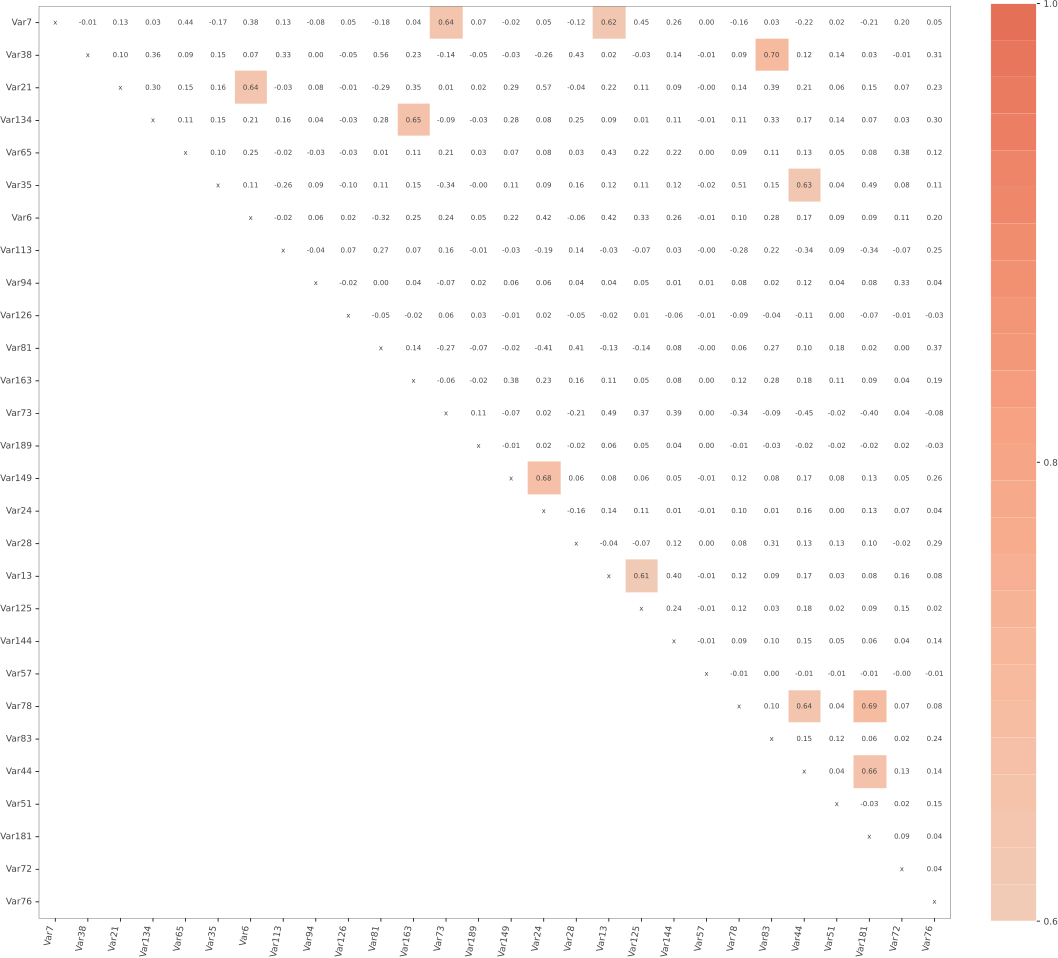

In [55]:
viz = plot_corr_heatmap(X_balanced_scaled_upselling[set(continuous_cols) - set(to_drop_upselling)], figsize=(15,15), label_fontsize=9, value_fontsize=7)
viz

#### Correlation plot for Appetency

In [53]:
corr_matrix_appetency = feature_corr_matrix(X_balanced_scaled_appetency).abs()

# Select upper triangle of correlation matrix
upper = corr_matrix_appetency.where(np.triu(np.ones(corr_matrix_appetency.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.70
to_drop_appetency = [column for column in upper.columns if any(upper[column] > 0.70)]

# Drop features 
print("Total columns to drop due to high correlation=",len(to_drop_appetency))

Total columns to drop due to high correlation= 18


In [54]:
X_balanced_scaled_appetency.drop(to_drop_appetency, axis=1, inplace=True)
X_val_scaled_appetency.drop(to_drop_appetency, axis=1, inplace=True)

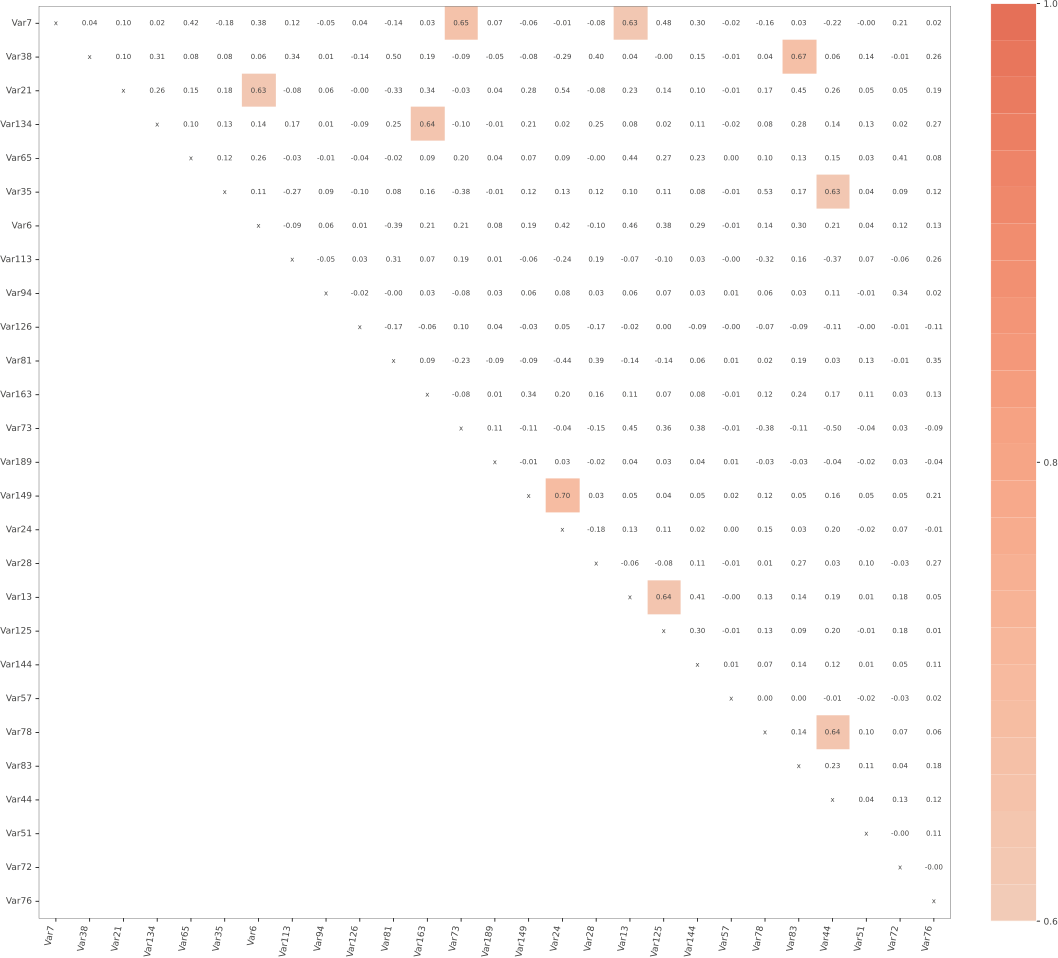

In [58]:
viz = plot_corr_heatmap(X_balanced_scaled_appetency[set(continuous_cols) - set(to_drop_appetency)], figsize=(15,15), label_fontsize=9, value_fontsize=7)
viz

### Table report after preprocessing

In [55]:
pretty_print(tbl_report(X_balanced_scaled, cols=['dtype', 'nulls', 'num_uniques', 'value_counts']))

Table Shape (22236, 60)


,dtype,nulls,num_uniques,value_counts
Var6,float64,0,1041,HC
Var7,float64,0,7,0.11299486593496198:10191-1.0951273191527116:66210.0755948602051773:23491.3211170510226355:20002.529239236110309:7043.7373614211979826:2784.945483606285656:93
Var13,float64,0,1837,HC
Var21,float64,0,494,HC
Var24,float64,0,63,HC
Var28,float64,0,2520,HC
Var35,float64,0,14,HC
Var38,float64,0,11587,HC
Var44,float64,0,7,-0.11355644966999817:199030.0009405244042010134:20446.163181632123221:22912.439919713916439:4918.716657795709658:943.82361012288253:124.993395877502874:1
Var51,float64,0,1233,HC


# Modeling

## Baseline Model

### Baseline model for Churn

In [68]:
ypred_baseline_one_churn = np.ones(X_val_scaled.shape[0], dtype="int")
print(confusion_matrix(y_val, ypred_baseline_one_churn))

[[   0 9266]
 [   0  734]]


In [69]:
print("ROC AUC score for Baseline Model where all the customers Churn is: ", roc_auc_score(y_val, ypred_baseline_one_churn))

ROC AUC score for Baseline Model where all the customers Churn is:  0.5


In [70]:
ypred_baseline_zero_churn = np.zeros(X_val_scaled.shape[0], dtype="int")
print(confusion_matrix(y_val, ypred_baseline_zero_churn))

[[9266    0]
 [ 734    0]]


In [71]:
print("ROC AUC score for Baseline Model where no customers Churn is: ", roc_auc_score(y_val, ypred_baseline_zero_churn))

ROC AUC score for Baseline Model where no customers Churn is:  0.5


### Baseline model for Upselling

In [72]:
ypred_baseline_one_upselling = np.ones(X_val_scaled_upselling.shape[0], dtype="int")
print(confusion_matrix(y_val_upselling, ypred_baseline_one_upselling))

[[   0 9264]
 [   0  736]]


In [73]:
print("ROC AUC score for Baseline Model with upselling=1 for all customers is: ", roc_auc_score(y_val_upselling, ypred_baseline_one_upselling))

ROC AUC score for Baseline Model with upselling=1 for all customers is:  0.5


In [74]:
ypred_baseline_zero_upselling = np.zeros(X_val_scaled_upselling.shape[0], dtype="int")
print(confusion_matrix(y_val_upselling, ypred_baseline_zero_upselling))

[[9264    0]
 [ 736    0]]


In [75]:
print("ROC AUC score for Baseline Model with upselling=0 for all customers is: ", roc_auc_score(y_val_upselling, ypred_baseline_zero_upselling))

ROC AUC score for Baseline Model with upselling=0 for all customers is:  0.5


### Baseline Model for appetency

In [76]:
ypred_baseline_one_appetency = np.ones(X_val_scaled_appetency.shape[0], dtype="int")
print(confusion_matrix(y_val_appetency, ypred_baseline_one_appetency))

[[   0 9822]
 [   0  178]]


In [77]:
print("ROC AUC score for Baseline Model with appetency=1 for all customers is: ", roc_auc_score(y_val_appetency, ypred_baseline_one_appetency))

ROC AUC score for Baseline Model with appetency=1 for all customers is:  0.5


In [78]:
ypred_baseline_zero_appetency = np.zeros(X_val_scaled_appetency.shape[0], dtype="int")
print(confusion_matrix(y_val_appetency, ypred_baseline_zero_appetency))

[[9822    0]
 [ 178    0]]


In [80]:
print("ROC AUC score for Baseline Model where no customers Churn is: ", roc_auc_score(y_val_appetency, ypred_baseline_zero_appetency))

ROC AUC score for Baseline Model where no customers Churn is:  0.5


In [79]:
def cv_optimize(clf, parameters, X, y, n_jobs=-1, n_folds=5, score_func=None):
    if score_func:
        print("SCORE FUNC", score_func)
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print("BEST", gs.best_params_, gs.best_score_)
    best = gs.best_estimator_
    return best

In [61]:
def do_classify(clf, parameters, X_train, y_train, X_val, y_val, 
                featurenames, 
                score_func, n_folds=5, n_jobs=-1):
    if parameters:
        clf = cv_optimize(clf, parameters, X_train, y_train, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    val_score = clf.score(X_val, y_val)
    print("############# based on standard predict 0.5 ################")
    print("ROC AUC score on training data: %0.2f" % (train_score))
    print("ROC AUC precision score on validation data:     %0.2f" % (val_score))
    print(confusion_matrix(y_val, clf.predict(X_val)))
    print("########################################################")
    return clf, dict(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val)

In [62]:
def make_roc(name, clf, ytest, xtest, ax=None, labe=5,  proba=True, skip=0, initial = False):
    if not ax:
        ax=plt.gca()
    if proba:
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', lw=2, alpha=0.4, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', lw=2, alpha=0.4, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    for k in range(0, fpr.shape[0],labe+10):
        #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
        threshold = str(np.round(thresholds[k], 2))
        ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

In [63]:
def get_best_threshold(est, X_val, y_val):
    # predict probabilities
    yhat = est.predict_proba(X_val)
    y_pred = est.predict(X_val)
    # keep probabilities for the positive outcome only
    yhat = yhat[:, 1]
    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(y_val, yhat)
    # calculate the g-mean for each threshold
    gmeans = sqrt(tpr * (1-fpr))
    # locate the index of the largest g-mean
    ix = argmax(gmeans)
    print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
    print()
    # plot the roc curve for the model
    plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label='Logistic')
    plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    # show the plot
    plt.show()
    return thresholds[ix]

In [64]:
def repredict(est,t, xtest):
    probs=est.predict_proba(xtest)
    p0 = probs[:,0]
    p1 = probs[:,1]
    ypred = (p1 >= t)*1
    return ypred

## Logistic Regression

### Modeling for Churn

In [ ]:
param_grid_lr = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

In [ ]:
lr = LogisticRegression(max_iter=10000, penalty='l2')

#### Training the best model with GridSearchCV

In [ ]:
# lr, _  = do_classify(lr, param_grid_lr, X_balanced_scaled, y_balanced, X_val_scaled, y_val, X_balanced_scaled.columns, score_func='roc_auc')


SCORE FUNC roc_auc
BEST {'C': 0.01} 0.6585113087460936
############# based on standard predict 0.5 ################
ROC AUC score on training data: 0.68
ROC AUC precision score on validation data:     0.87
[[8573  693]
 [ 596  138]]
########################################################


#### Saving the best model

In [ ]:
lr_model_filename = '/content/drive/MyDrive/UnivAI/ML-2 project/model/LR_model_new.pickle'

In [ ]:
#pickle.dump(lr, open(lr_model_filename, 'wb'))

In [ ]:
lr = pickle.load(open(lr_model_filename, 'rb'))

In [ ]:
print("Best Logistic Regression model is : ",lr)


Best Logistic Regression model is :  LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


#### Predicting Churn


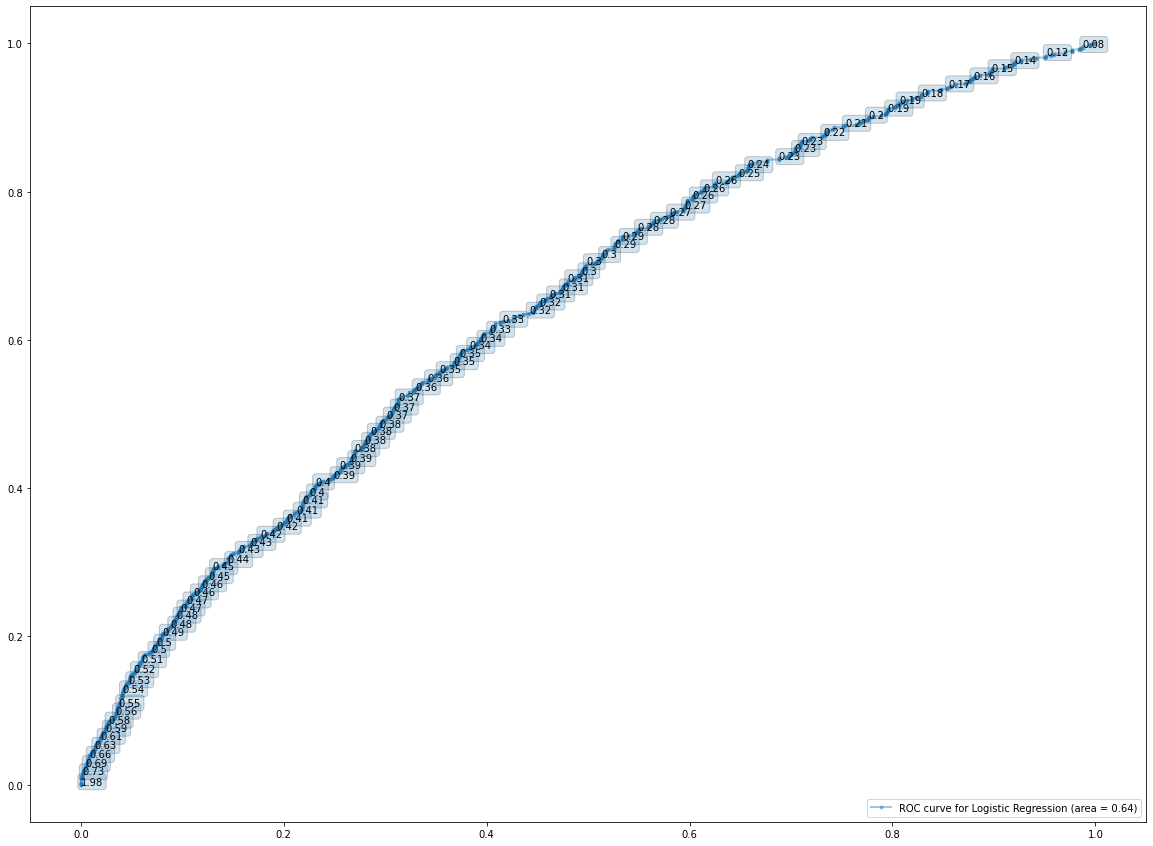

In [ ]:
plt.figure(figsize=(20,15))
make_roc('Logistic Regression', lr, y_val, X_val_scaled)

**From the plot, we can see that the ROC AUC score for Logistic Regression Model is 0.64**

Best Threshold=0.332938, G-Mean=0.607



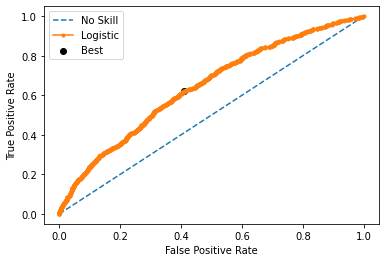

The best threshold for Random Forest Model is:  0.33293809057506535


In [ ]:
best_threshold_lr = get_best_threshold(lr, X_val_scaled, y_val.values)
print("The best threshold for Random Forest Model is: ", best_threshold_lr)

Now, let's repredict whether the customer will churn or not, based on the best threshold obtained.

In [ ]:
y_pred_val_lr = repredict(lr, best_threshold_lr, X_val_scaled)

In [ ]:
fscore_lr = f1_score(y_pred_val_lr,y_val.values)
print("fscore for Logistic Regression model with the best threshold={:.2f}".format(fscore_lr))

fscore for Logistic Regression model with the best threshold=0.18


### Modeling for upselling

#### Training the best model with GridSearchCV

In [65]:
param_grid_lr = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

In [66]:
lr_upselling = LogisticRegression(max_iter=10000, penalty='l2')

In [67]:
# lr_upselling, _  = do_classify(lr_upselling, param_grid_lr, X_balanced_scaled_upselling, y_balanced_upselling, X_val_scaled_upselling, y_val_upselling, X_balanced_scaled_upselling.columns, score_func='roc_auc')


SCORE FUNC roc_auc


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


BEST {'C': 10} 0.7688452614459432
############# based on standard predict 0.5 ################
ROC AUC score on training data: 0.75
ROC AUC precision score on validation data:     0.86
[[8245 1019]
 [ 388  348]]
########################################################


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


#### Saving the best model

In [68]:
lr_model_upselling_filename = '/content/drive/MyDrive/UnivAI/ML-2 project/model/LR_model_upselling_new.pickle'

In [72]:
# pickle.dump(lr_upselling, open(lr_model_upselling_filename, 'wb'))

In [73]:
lr_upselling = pickle.load(open(lr_model_upselling_filename, 'rb'))

In [74]:
print("Best Logistic Regression model for Upselling prediction is : ",lr_upselling)


Best Logistic Regression model for Upselling prediction is :  LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


#### Predicting upselling

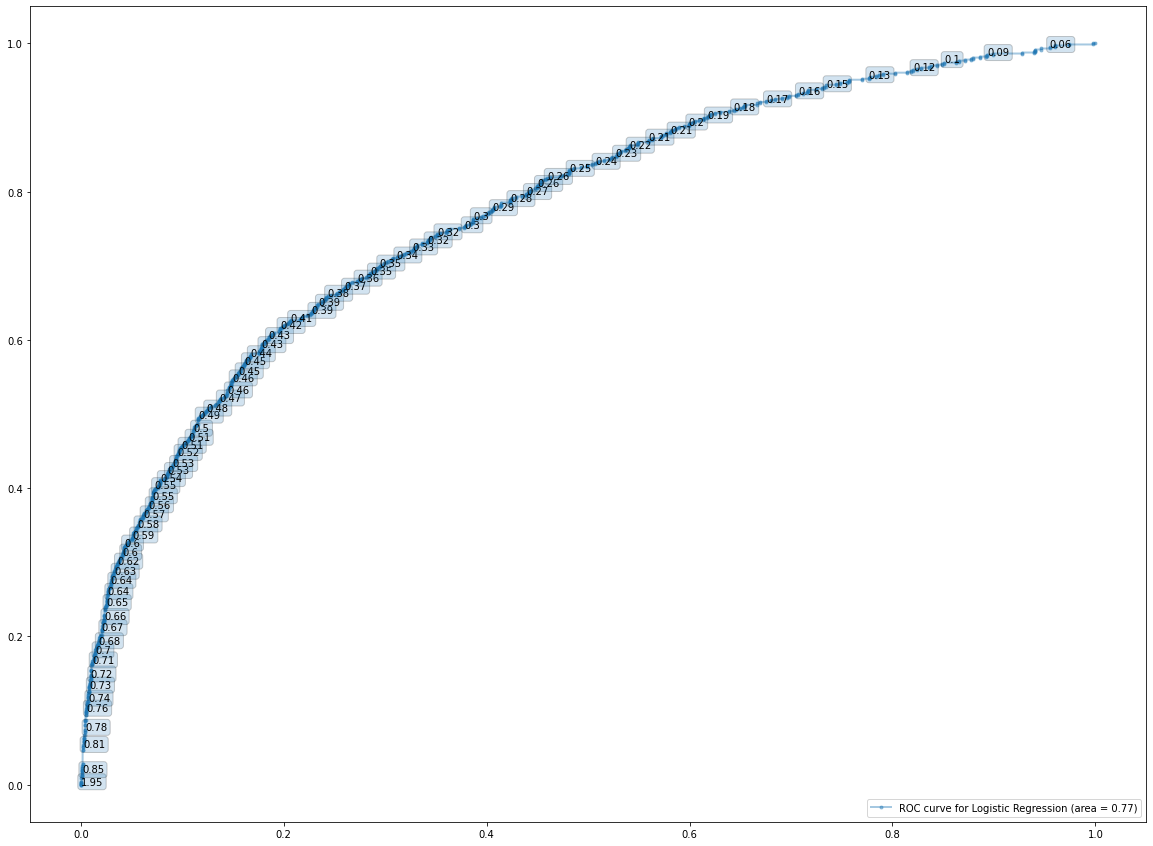

In [75]:
plt.figure(figsize=(20,15))
make_roc('Logistic Regression', lr_upselling, y_val_upselling, X_val_scaled_upselling)

**From the plot, we can see that the ROC AUC score for Logistic Regression Model is 0.77**

Best Threshold=0.380106, G-Mean=0.706



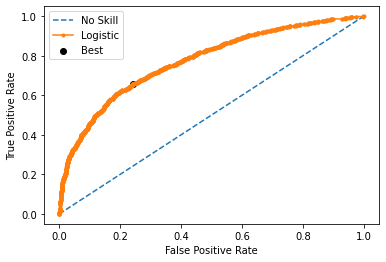

The best threshold for Logistic Regression Model is:  0.38010649048098627


In [77]:
best_threshold_lr_upselling = get_best_threshold(lr_upselling, X_val_scaled_upselling, y_val_upselling.values)
print("The best threshold for Logistic Regression Model is: ", best_threshold_lr_upselling)

Now, let's repredict whether the customer will churn or not, based on the best threshold obtained.

In [78]:
y_pred_val_lr_upselling = repredict(lr_upselling, best_threshold_lr_upselling, X_val_scaled_upselling)

In [79]:
fscore_lr_upselling = f1_score(y_pred_val_lr_upselling,y_val_upselling.values)
print("fscore for Logistic Regression model with the best threshold={:.2f}".format(fscore_lr_upselling))

fscore for Logistic Regression model with the best threshold=0.28


### Modeling for appetency

#### Training the best model with GridSearchCV

In [80]:
param_grid_lr = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

In [81]:
lr_appetency = LogisticRegression(max_iter=10000, penalty='l2')

In [82]:
# lr_appetency, _  = do_classify(lr_appetency, param_grid_lr, X_balanced_scaled_appetency, y_balanced_appetency, X_val_scaled_appetency, y_val_appetency, X_balanced_scaled_appetency.columns, score_func='roc_auc')


SCORE FUNC roc_auc
BEST {'C': 1} 0.8125731284905374
############# based on standard predict 0.5 ################
ROC AUC score on training data: 0.77
ROC AUC precision score on validation data:     0.86
[[8511 1311]
 [ 100   78]]
########################################################


#### Saving the best model

In [83]:
lr_model_appetency_filename = '/content/drive/MyDrive/UnivAI/ML-2 project/model/LR_model_appetency_new.pickle'

In [84]:
# pickle.dump(lr_appetency, open(lr_model_appetency_filename, 'wb'))

In [85]:
lr_appetency = pickle.load(open(lr_model_appetency_filename, 'rb'))

In [86]:
print("Best Logistic Regression model for Appetency prediction is : ",lr_appetency)


Best Logistic Regression model for Appetency prediction is :  LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


#### Predicting appetency

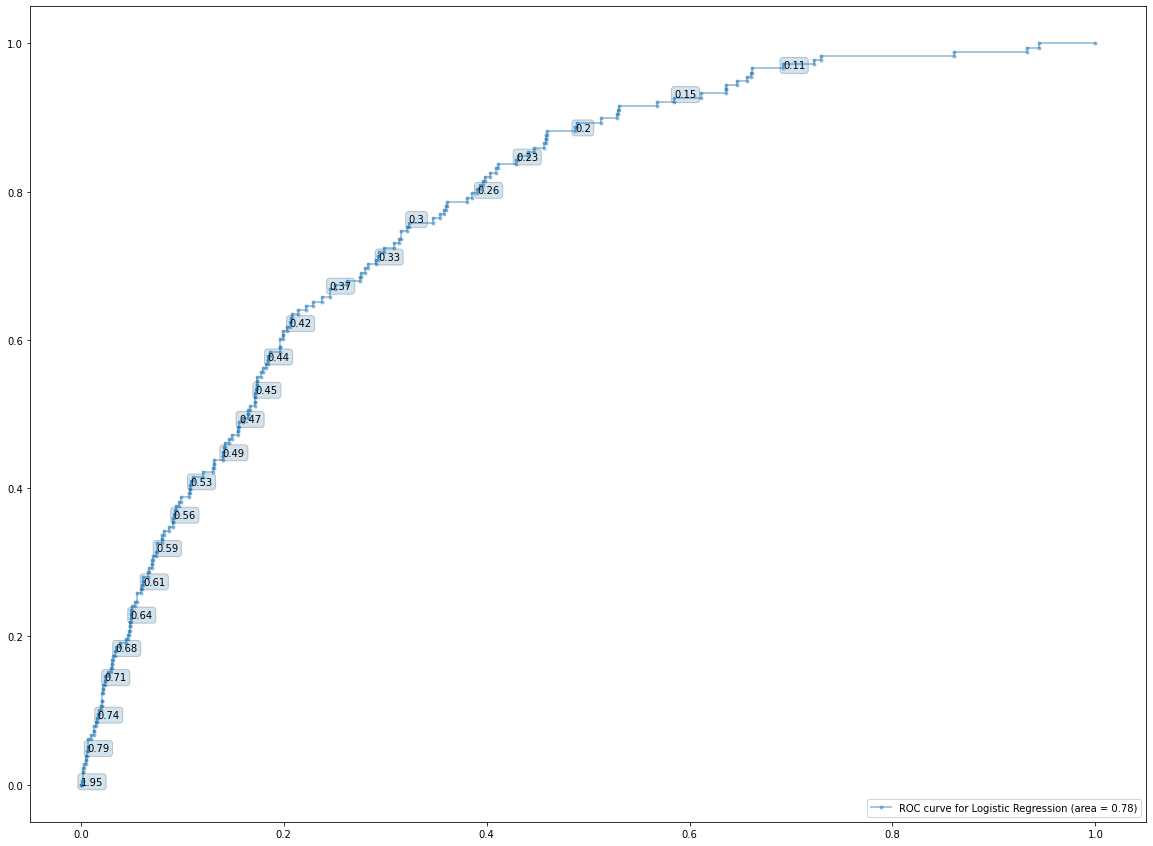

In [87]:
plt.figure(figsize=(20,15))
make_roc('Logistic Regression', lr_appetency, y_val_appetency, X_val_scaled_appetency)

**From the plot, we can see that the ROC AUC score for Logistic Regression Model is 0.78**

Best Threshold=0.304839, G-Mean=0.716



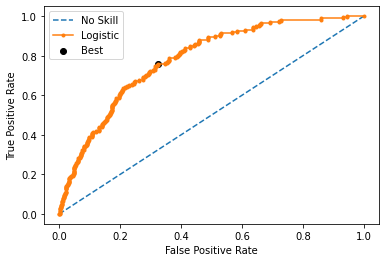

The best threshold for Random Forest Model is:  0.3048386440539811


In [88]:
best_threshold_lr_appetency = get_best_threshold(lr_appetency, X_val_scaled_appetency, y_val_appetency.values)
print("The best threshold for Logistic Regression Model is: ", best_threshold_lr_appetency)

Now, let's repredict whether the customer will churn or not, based on the best threshold obtained.

In [89]:
y_pred_val_lr_appetency = repredict(lr_appetency, best_threshold_lr_appetency, X_val_scaled_appetency)

In [90]:
fscore_lr_appetency = f1_score(y_pred_val_lr_appetency,y_val_appetency.values)
print("fscore for Logistic Regression model with the best threshold={:.2f}".format(fscore_lr_appetency))

fscore for Logistic Regression model with the best threshold=0.08


## Random Forest

### Modeling for Churn

In [ ]:
# rf = RandomForestClassifier(warm_start=True, oob_score=True, n_jobs=-1, random_state=66)
# param_grid_rf = { "n_estimators": range(500,1000, 100), "max_depth": range(5,9)}

#### Training the best model with GridSearchCV

In [ ]:
#rf, _  = do_classify(rf, param_grid_rf, X_balanced_scaled, y_balanced, X_val_scaled, y_val.values, X_balanced_scaled.columns, score_func='roc_auc')

SCORE FUNC roc_auc 
 BEST {'max_depth': 8, 'n_estimators': 900} 0.8054252185782842 
 /usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:359: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees. 
   warn("Warm-start fitting without increasing n_estimators does not " 
   ############# based on standard predict 0.5 ################ 
 ROC AUC score on training data: 0.75 
 ROC AUC precision score on validation data:     0.91 
 [[8946  320]
  [ 623  111]]


#### Saving the best model

In [83]:
rf_model_filename = '/content/drive/MyDrive/UnivAI/ML-2 project/model/rf_model_900.pickle'

In [ ]:
#pickle.dump(rf, open(rf_model_filename, 'wb'))

In [84]:
rf = pickle.load(open(rf_model_filename, 'rb'))

In [ ]:
print("Best Random Forest model is : ",rf)

Best Random Forest model is :  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=900,
                       n_jobs=-1, oob_score=True, random_state=66, verbose=0,
                       warm_start=True)


#### Predicting Churn

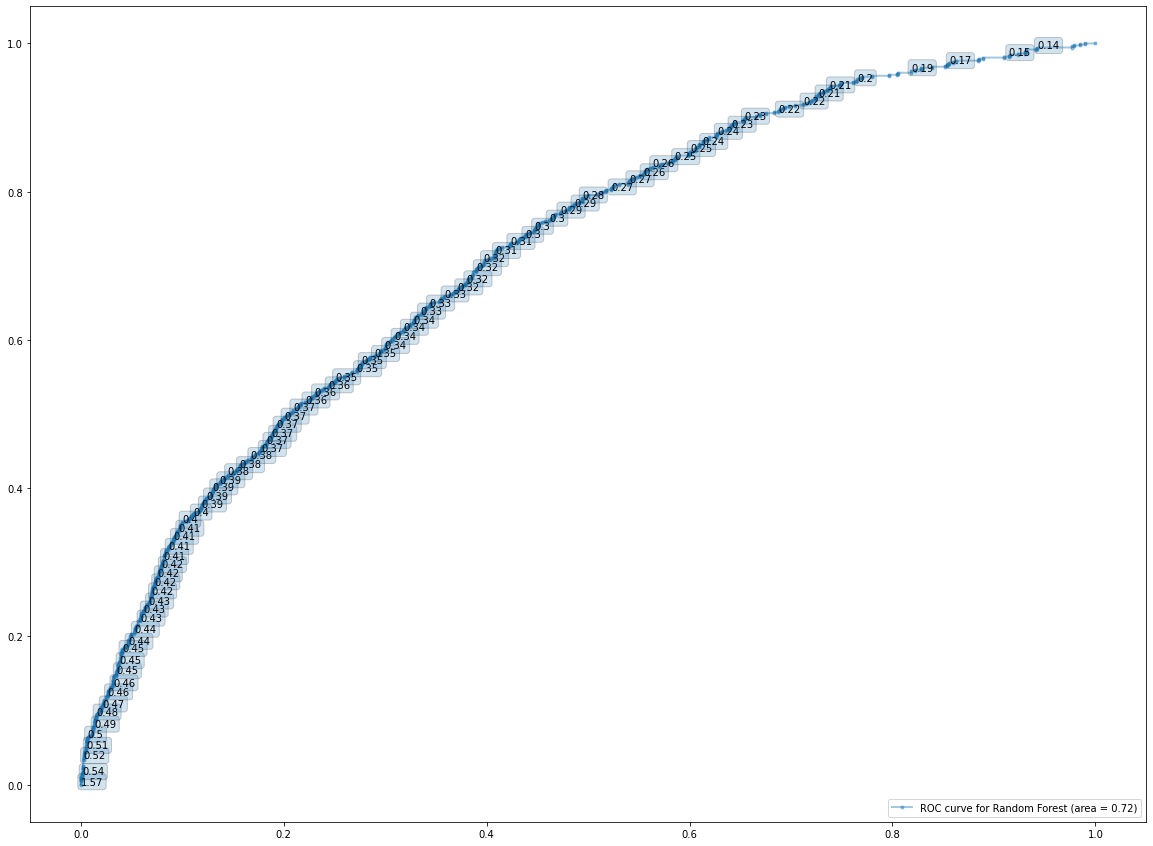

In [ ]:
plt.figure(figsize=(20,15))
make_roc('Random Forest', rf, y_val.values, X_val_scaled)

***From the plot, we can see that the ROC AUC score for Random Forest Model is 0.72***

Best Threshold=0.315631, G-Mean=0.653



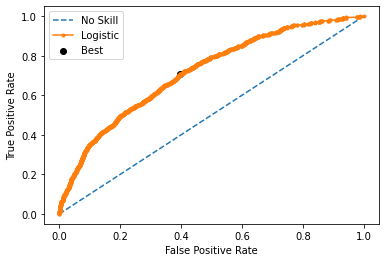

The best threshold for Random Forest Model is:  0.3156313027403598


In [ ]:
best_threshold_rf = get_best_threshold(rf, X_val_scaled, y_val.values)
print("The best threshold for Random Forest Model is: ", best_threshold_rf)

Now, let's repredict whether the customer will churn or not, based on the best threshold obtained.

In [ ]:
y_pred_val_rf = repredict(rf, best_threshold_rf, X_val_scaled)

In [ ]:
fscore_rf = f1_score(y_pred_val_rf,y_val.values)
print("fscore for Random Forest model with the best threshold={:.2f}".format(fscore_rf))

fscore for Random Forest model with the best threshold=0.21


### Modeling for upselling

In [175]:
# rf_upselling = RandomForestClassifier(warm_start=True, oob_score=True, n_jobs=-1, random_state=66)
# param_grid_rf = { "n_estimators": range(500,1000, 100), "max_depth": range(5,9)}

#### Training the best model with GridSearchCV

In [176]:
# rf_upselling, _  = do_classify(rf_upselling, param_grid_rf, X_balanced_scaled_upselling, y_balanced_upselling, X_val_scaled_upselling, y_val_upselling.values, X_balanced_scaled_upselling.columns, score_func='roc_auc')

SCORE FUNC roc_auc
BEST {'max_depth': 8, 'n_estimators': 900} 0.9070038391421302


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:359: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


############# based on standard predict 0.5 ################
ROC AUC score on training data: 0.82
ROC AUC precision score on validation data:     0.95
[[9119  145]
 [ 372  364]]
########################################################


#### Saving the best model

In [179]:
rf_model_upselling_filename = '/content/drive/MyDrive/UnivAI/ML-2 project/rf_upselling'

In [180]:
# pickle.dump(rf_upselling, open(rf_model_upselling_filename, 'wb'))

In [181]:
rf_upselling = pickle.load(open(rf_model_upselling_filename, 'rb'))

In [182]:
print("Best Random Forest model is : ",rf_upselling)

Best Random Forest model is :  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=900,
                       n_jobs=-1, oob_score=True, random_state=66, verbose=0,
                       warm_start=True)


#### Predicting upselling

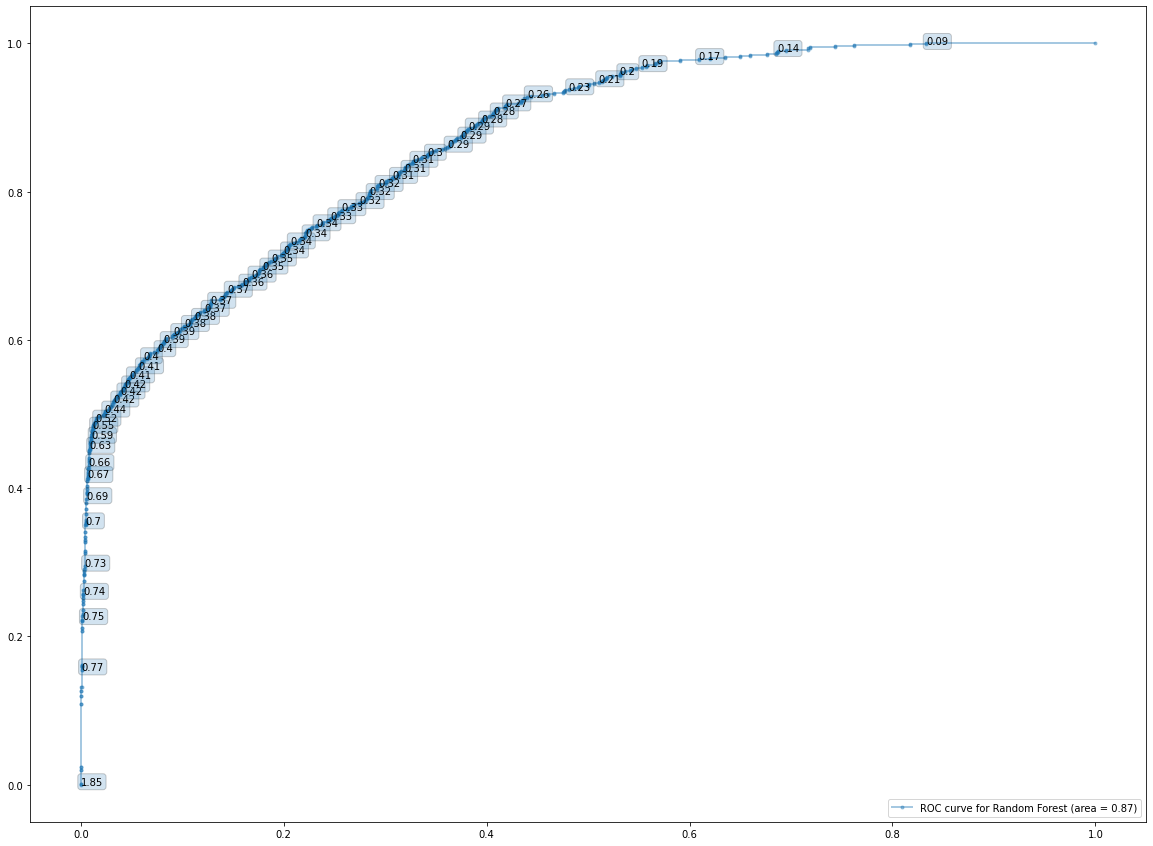

In [183]:
plt.figure(figsize=(20,15))
make_roc('Random Forest', rf_upselling, y_val_upselling.values, X_val_scaled_upselling)

***From the plot, we can see that the ROC AUC score for Random Forest Model is 0.87***

Best Threshold=0.338257, G-Mean=0.763



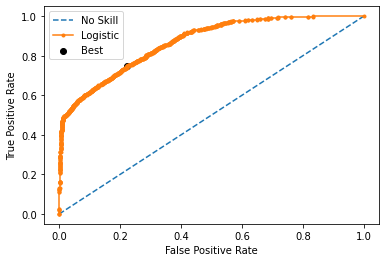

The best threshold for Random Forest Model is:  0.3382565391420651


In [184]:
best_threshold_rf_upselling = get_best_threshold(rf_upselling, X_val_scaled_upselling, y_val_upselling.values)
print("The best threshold for Random Forest Model is: ", best_threshold_rf_upselling)

Now, let's repredict whether the customer will churn or not, based on the best threshold obtained.

In [185]:
y_pred_val_rf_upselling = repredict(rf_upselling, best_threshold_rf_upselling, X_val_scaled_upselling)

In [186]:
fscore_rf_upselling = f1_score(y_pred_val_rf_upselling,y_val_upselling.values)
print("fscore for Random Forest model with the best threshold={:.2f}".format(fscore_rf_upselling))

fscore for Random Forest model with the best threshold=0.33


### Modeling for appetency

In [ ]:
# rf_appetency = RandomForestClassifier(warm_start=True, oob_score=True, n_jobs=-1, random_state=66)
# param_grid_rf = { "n_estimators": range(500,1000, 100), "max_depth": range(5,9)}

#### Training the best model with GridSearchCV

In [106]:
#rf_appetency, _  = do_classify(rf_appetency, param_grid_rf, X_balanced_scaled_appetency, y_balanced_appetency, X_val_scaled_appetency, y_val_appetency.values, X_balanced_scaled_appetency.columns, score_func='roc_auc')

SCORE FUNC roc_auc
BEST {'max_depth': 8, 'n_estimators': 700} 0.9531647502595326
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:359: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "
############# based on standard predict 0.5 ################
ROC AUC score on training data: 0.88
ROC AUC precision score on validation data:     0.93
[[9206  616]
 [ 122   56]]
########################################################


#### Saving the best model

In [107]:
rf_model_appetency_filename = '/content/drive/MyDrive/UnivAI/ML-2 project/rf_appetency'

In [108]:
#pickle.dump(rf_appetency, open(rf_model_appetency_filename, 'wb'))

In [109]:
rf_appetency = pickle.load(open(rf_model_appetency_filename, 'rb'))

In [110]:
print("Best Random Forest model is : ",rf_appetency)

Best Random Forest model is :  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=700,
                       n_jobs=-1, oob_score=True, random_state=66, verbose=0,
                       warm_start=True)


#### Predicting appetency

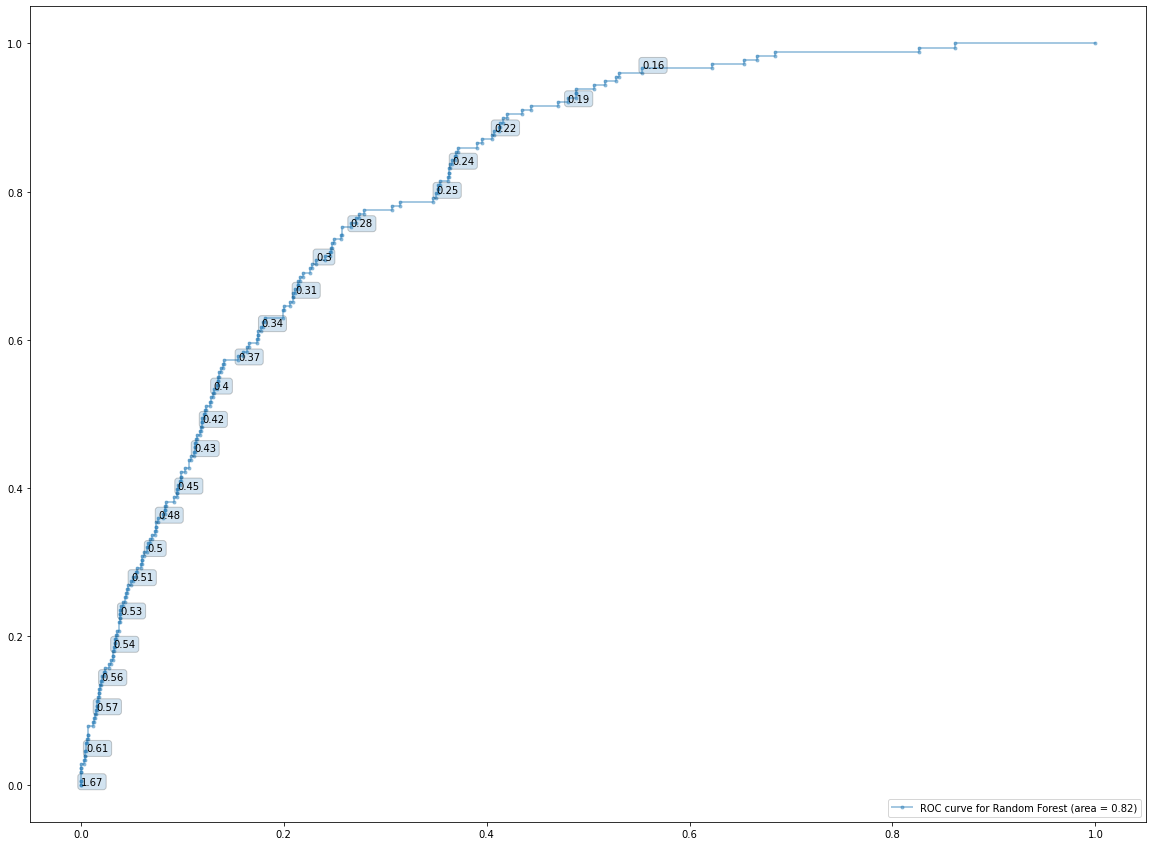

In [111]:
plt.figure(figsize=(20,15))
make_roc('Random Forest', rf_appetency, y_val_appetency.values, X_val_scaled_appetency)

***From the plot, we can see that the ROC AUC score for Random Forest Model is 0.82***

Best Threshold=0.315631, G-Mean=0.653



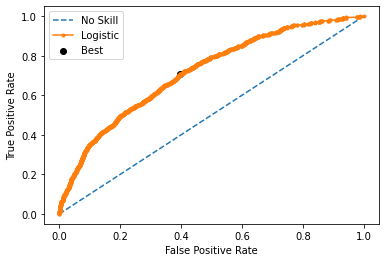

The best threshold for Random Forest Model is:  0.3156313027403598


In [ ]:
best_threshold_rf_appetency = get_best_threshold(rf_appetency, X_val_scaled_appetency, y_val_appetency.values)
print("The best threshold for Random Forest Model is: ", best_threshold_rf_appetency)

Now, let's repredict whether the customer will churn or not, based on the best threshold obtained.

In [ ]:
fscore_rf_appetency = f1_score(y_pred_val_rf_appetency,y_val_appetency.values)
print("fscore for Random Forest model with the best threshold={:.2f}".format(fscore_rf_appetency))

fscore for Random Forest model with the best threshold=0.21


In [ ]:
y_pred_val_rf_appetency = repredict(rf_appetency, best_threshold_rf_appetency, X_val_scaled_appetency)

## Gradient Boosting

### Modeling for Churn

#### Training the best model with GridSearchCV

In [ ]:
gb = GradientBoostingClassifier(warm_start=True, random_state=66)

In [ ]:
param_grid_gb = { "n_estimators": range(400,1000, 100), "max_depth": range(3,7), "learning_rate": [0.01, 0.1]}

**Please note:**

Running the below cell takes nearly 7-8 hrs

In [ ]:
# gb, _  = do_classify(gb, param_grid_gb, X_balanced_scaled, y_balanced, X_val_scaled, y_val.values, X_balanced_scaled.columns, score_func='roc_auc')

SCORE FUNC roc_auc
BEST {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 900} 0.9698410375004689
############# based on standard predict 0.5 ################
Average precision score on training data: 1.00
Average precision score on validation data:     0.90
[[8867  399]
 [ 596  138]]
########################################################


#### Saving the best model

In [ ]:
filename = '/content/drive/MyDrive/UnivAI/ML-2 project/model/gradientboost_best_final.pickle'

In [ ]:
# pickle.dump(gb, open(filename, 'wb'))

In [ ]:
gb_best = pickle.load(open(filename, "rb"))

In [ ]:
gb = GradientBoostingClassifier(n_estimators=1000, max_depth=5, learning_rate=0.03, random_state=66)

In [ ]:
gb.fit(X_balanced_scaled, y_balanced)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.03, loss='deviance', max_depth=5,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=1000,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=66, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

#### Predicting Churn

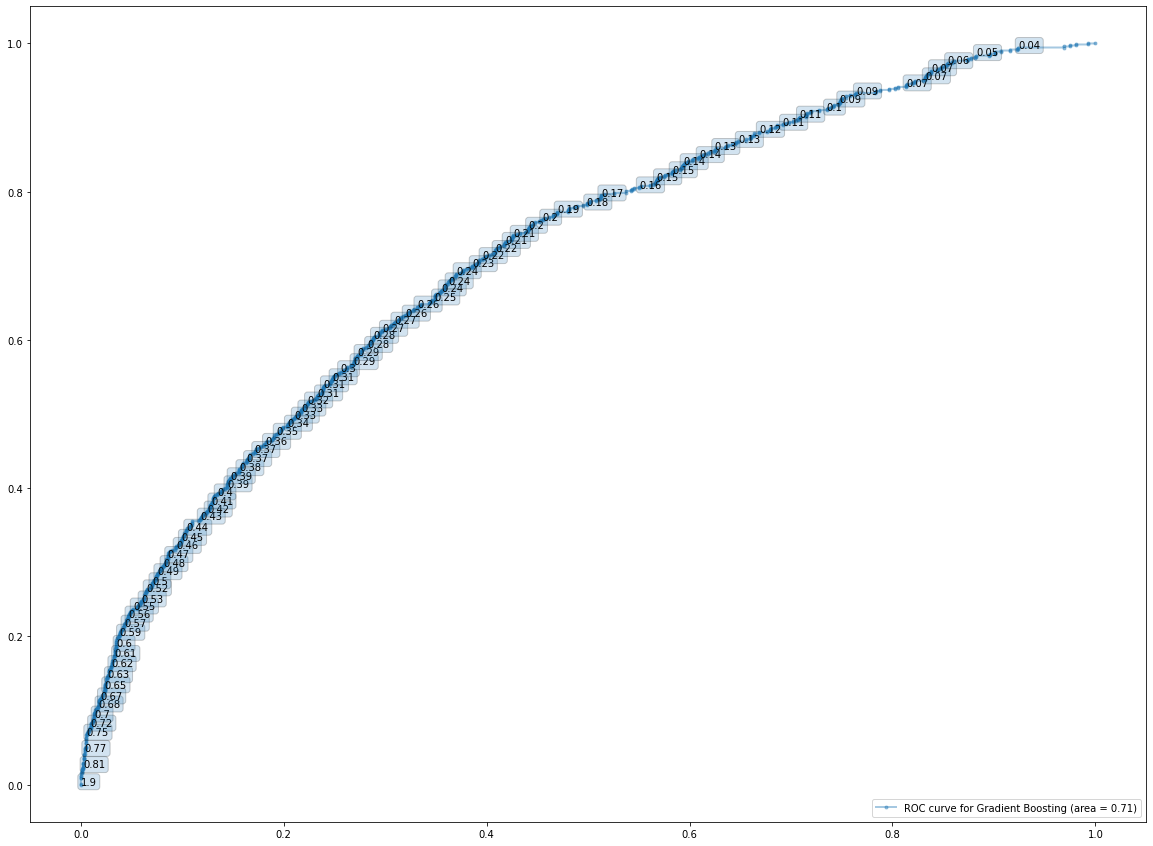

In [ ]:
plt.figure(figsize=(20,15))
make_roc('Gradient Boosting', gb, y_val.values, X_val_scaled)

Best Threshold=0.235215, G-Mean=0.659



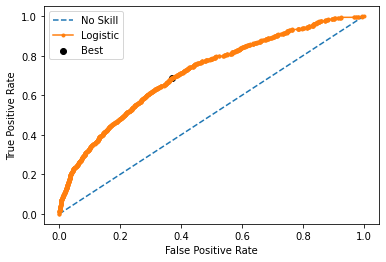

In [ ]:
best_threshold_gb = get_best_threshold(gb, X_val_scaled, y_val.values)

In [ ]:
y_pred = repredict(gb, best_threshold_gb, X_val_scaled)

In [ ]:
fscore = f1_score(y_pred,y_val.values)
print("fscore for best threshold={:.2f}".format(fscore))

fscore for best threshold=0.22


### Modeling for Upselling

#### Training the best model with GridSearchCV

In [ ]:
gb_upselling = GradientBoostingClassifier(warm_start=True, random_state=66)

In [ ]:
param_grid_gb = { "n_estimators": range(400,1000, 100), "max_depth": range(3,7), "learning_rate": [0.01, 0.1]}

**Please note:**

Running the below cell takes nearly 7-8 hrs

In [ ]:
# gb_upselling, _  = do_classify(gb_upselling, param_grid_gb, X_balanced_scaled_upselling, y_balanced_upselling, X_val_scaled_upselling, y_val_upselling.values, X_balanced_scaled_upselling.columns, score_func='roc_auc')

SCORE FUNC roc_auc
BEST {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 900} 0.9698410375004689
############# based on standard predict 0.5 ################
Average precision score on training data: 1.00
Average precision score on validation data:     0.90
[[8867  399]
 [ 596  138]]
########################################################


#### Saving the best model

In [160]:
filename_upselling = '/content/drive/MyDrive/UnivAI/ML-2 project/model/gradientboost_best_upselling_final.pickle'

In [169]:
# pickle.dump(gb_upselling, open(filename_upselling, 'wb'))

In [170]:
gb_best_upselling = pickle.load(open(filename_upselling, "rb"))

In [162]:
gb_upselling = GradientBoostingClassifier(n_estimators=1000, max_depth=5, learning_rate=0.03, random_state=66)

In [163]:
gb_upselling.fit(X_balanced_scaled_upselling, y_balanced_upselling)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.03, loss='deviance', max_depth=5,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=1000,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=66, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

#### Predicting upselling

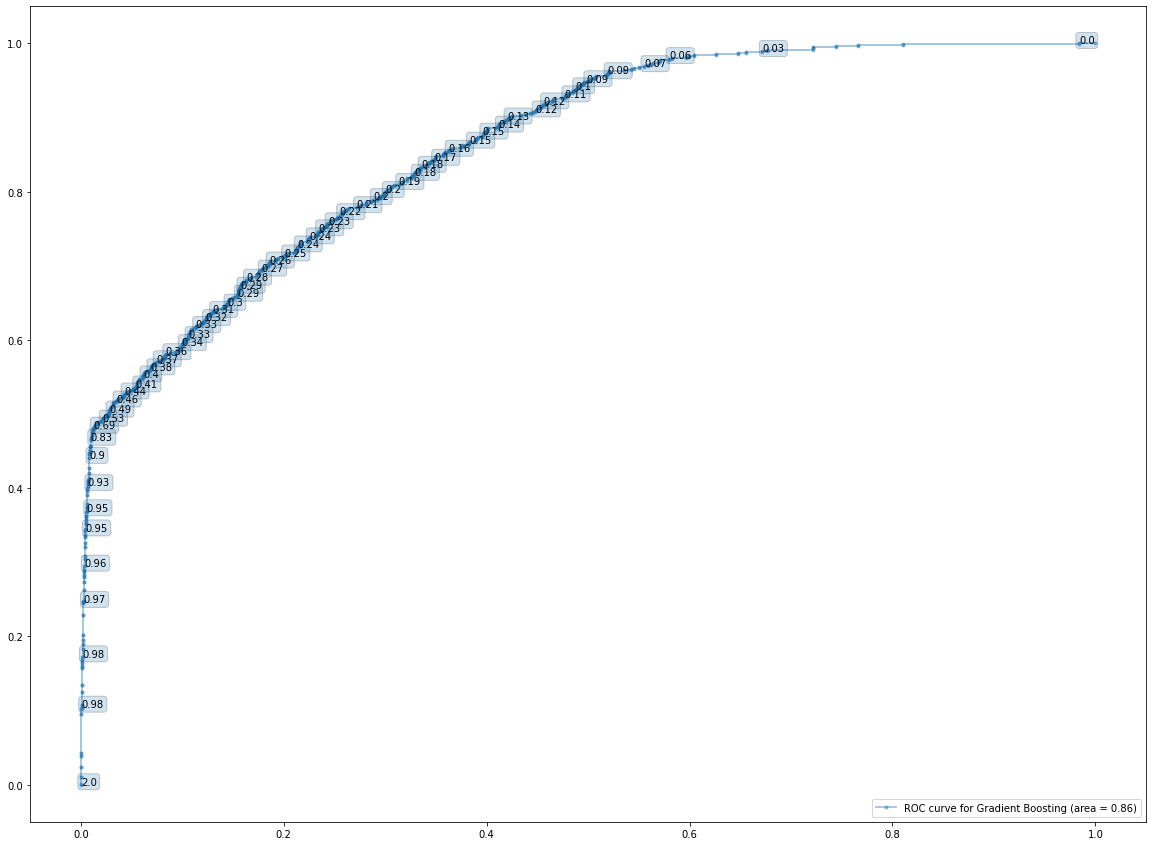

In [164]:
plt.figure(figsize=(20,15))
make_roc('Gradient Boosting', gb_upselling, y_val_upselling.values, X_val_scaled_upselling)

Best Threshold=0.262123, G-Mean=0.758



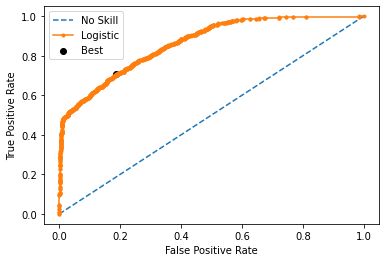

In [165]:
best_threshold_gb_upselling = get_best_threshold(gb_upselling, X_val_scaled_upselling, y_val_upselling.values)

In [166]:
y_pred_upselling = repredict(gb_upselling, best_threshold_gb_upselling, X_val_scaled_upselling)

In [167]:
fscore_upselling = f1_score(y_pred_upselling,y_val_upselling.values)
print("fscore for best threshold={:.2f}".format(fscore_upselling))

fscore for best threshold=0.35


### Modeling for Appetency

#### Training the best model with GridSearchCV

In [ ]:
gb_appetency = GradientBoostingClassifier(warm_start=True, random_state=66)

In [ ]:
param_grid_gb = { "n_estimators": range(400,1000, 100), "max_depth": range(3,7), "learning_rate": [0.01, 0.1]}

**Please note:**

Running the below cell takes nearly 7-8 hrs

In [ ]:
# gb_appetency, _  = do_classify(gb_appetency, param_grid_gb, X_balanced_scaled_appetency, y_balanced_appetency, X_val_scaled_appetency, y_val_appetency.values, X_balanced_scaled_appetency.columns, score_func='roc_auc')

SCORE FUNC roc_auc
BEST {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 900} 0.9698410375004689
############# based on standard predict 0.5 ################
Average precision score on training data: 1.00
Average precision score on validation data:     0.90
[[8867  399]
 [ 596  138]]
########################################################


#### Saving the best model

In [171]:
filename_appetency = '/content/drive/MyDrive/UnivAI/ML-2 project/model/gradientboost_best_appetency_final.pickle'

In [177]:
# pickle.dump(gb_appetency, open(filename_appetency, 'wb'))

In [178]:
gb_best_appetency = pickle.load(open(filename_appetency, "rb"))

In [172]:
gb_appetency = GradientBoostingClassifier(n_estimators=1000, max_depth=5, learning_rate=0.03, random_state=66)

In [173]:
gb_appetency.fit(X_balanced_scaled_appetency, y_balanced_appetency)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.03, loss='deviance', max_depth=5,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=1000,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=66, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

#### Predicting appetency

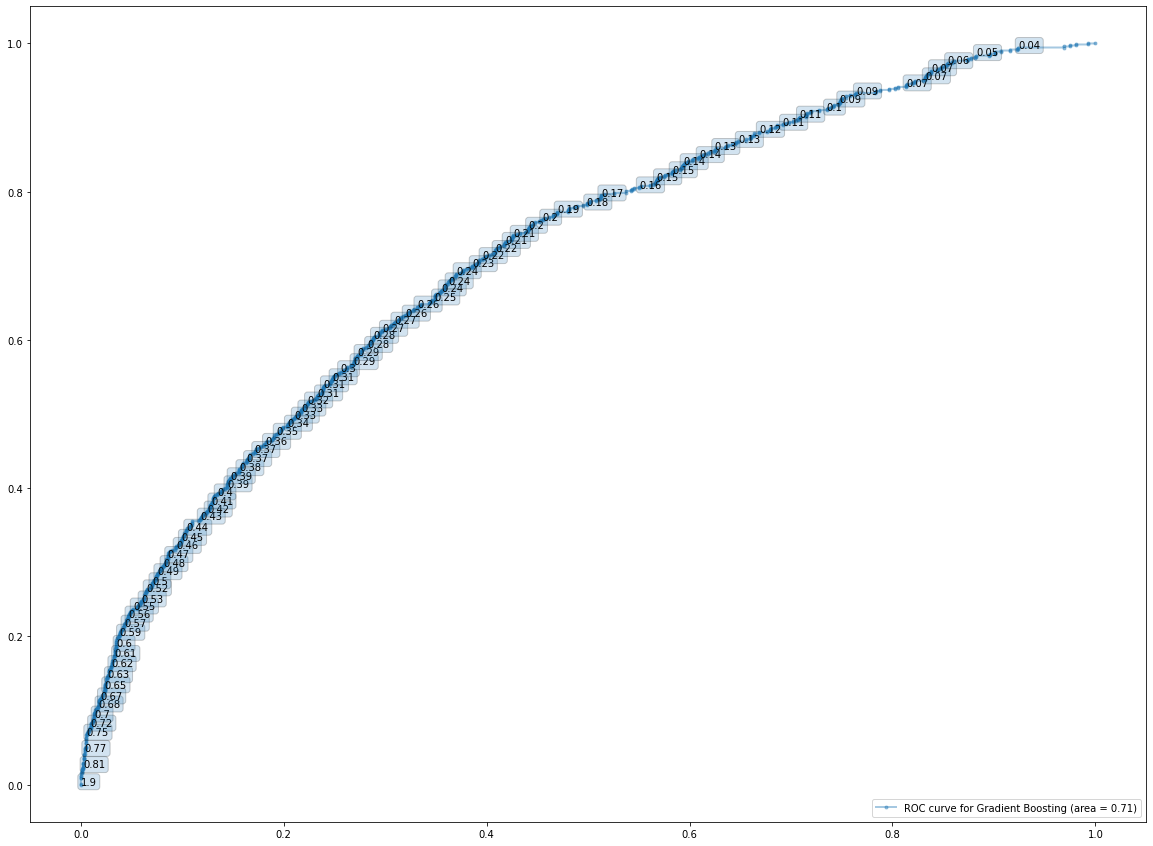

In [ ]:
plt.figure(figsize=(20,15))
make_roc('Gradient Boosting', gb_appetency, y_val_appetency.values, X_val_scaled_appetency)

Best Threshold=0.235215, G-Mean=0.659



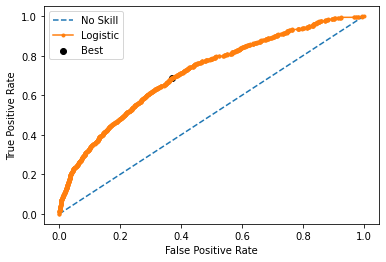

In [ ]:
best_threshold_gb_appetency = get_best_threshold(gb_appetency, X_val_scaled_appetency, y_val_appetency.values)

In [ ]:
y_pred_appetency = repredict(gb_appetency, best_threshold_gb_appetency, X_val_scaled_appetency)

In [ ]:
fscore_appetency = f1_score(y_pred_appetency,y_val_appetency.values)
print("fscore for best threshold={:.2f}".format(fscore_appetency))

fscore for best threshold=0.22


## XGBoost

### Modeling for Churn

#### Training the best model with GridSearchCV

In [ ]:
xgb = xgb.XGBClassifier()
# param_grid_xgb = { "n_estimators": [300,350,400,450,500,1000], "max_depth": [3,4,5,6,7,8,9], "learning_rate":[0.03,0.01,0.1]}
best_params_xgb = {'learning_rate': [0.1], 'max_depth': [9], 'n_estimators': [1000]}

In [174]:
# xgb_best, _ = do_classify(xgb, best_params_xgb, X_balanced_scaled, y_balanced, X_val_scaled, y_val.values, X_balanced_scaled.columns, score_func='roc_auc')


SCORE FUNC roc_auc
BEST {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 1000} 0.9736173156519932
############# based on standard predict 0.5 ################
ROC AUC score on training data: 1.00
ROC AUC precision score on validation data:     0.91
[[8926  340]
 [ 605  129]]
########################################################


#### Saving the best model

In [188]:
filename_xgb = '/content/drive/MyDrive/UnivAI/ML-2 project/model/xgb_best'
# pickle.dump(xgb_best, open(filename, 'wb'))
xgb_best = pickle.load(open(filename_xgb,'rb'))

In [189]:
print("Best XGBoost model is : ",xgb_best)

Best XGBoost model is :  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=nan, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


#### Predicting Churn

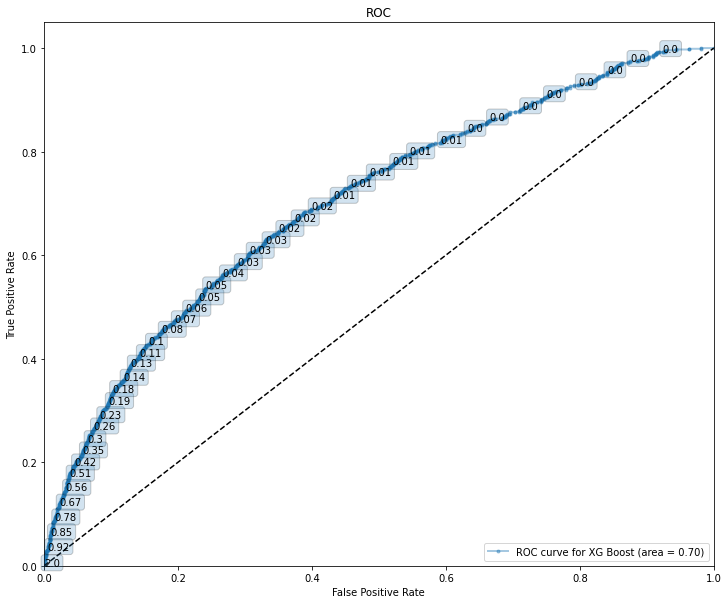

In [190]:
fig, ax = plt.subplots(figsize=(12,10))
make_roc('XG Boost',xgb_best,y_val.values,X_val_scaled,ax=ax,labe=20,initial=True)

From the plot, we can see that the ROC AUC score for Random Forest Model is 0.70

Best Threshold=0.025675, G-Mean=0.649



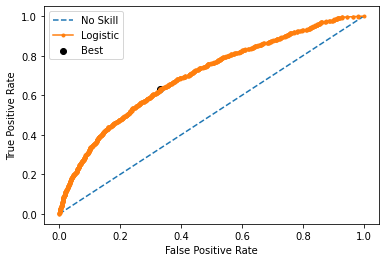

The best threshold for Random Forest Model is:  0.025674665


In [191]:
best_threshold_xgb = get_best_threshold(xgb_best, X_val_scaled, y_val.values)
print("The best threshold for Random Forest Model is: ", best_threshold_xgb)

Now, let's repredict whether the customer will churn or not, based on the best threshold obtained.

In [192]:
y_pred_val_xgb = repredict(xgb_best, best_threshold_xgb, X_val_scaled)

In [193]:
fscore_xgb = f1_score(y_pred_val_xgb,y_val.values)
print("fscore for Random Forest model with the best threshold={:.2f}".format(fscore_xgb))

fscore for Random Forest model with the best threshold=0.22


### Modeling for Upselling

#### Training the best model with GridSearchCV

In [194]:
xgb_upselling = xgb.XGBClassifier()
# param_grid_xgb = { "n_estimators": [300,350,400,450,500,1000], "max_depth": [3,4,5,6,7,8,9], "learning_rate":[0.03,0.01,0.1]}
best_params_xgb_upselling = {'learning_rate': [0.1], 'max_depth': [8], 'n_estimators': [900]}

In [195]:
# xgb_best_upselling, _ = do_classify(xgb_upselling, best_params_xgb_upselling, X_balanced_scaled_upselling, y_balanced_upselling, X_val_scaled_upselling, y_val_upselling.values, X_balanced_scaled_upselling.columns, score_func='roc_auc')


SCORE FUNC roc_auc
BEST {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 900} 0.9736173156519932
############# based on standard predict 0.5 ################
ROC AUC score on training data: 1.00
ROC AUC precision score on validation data:     0.91
[[8926  340]
 [ 605  129]]
########################################################


#### Saving the best model

In [196]:
xgb_upselling = xgb.XGBClassifier(n_estimators=900, max_depth=8, learning_rate=0.1, n_jobs=-1)
xgb_upselling.fit(X_balanced_scaled_upselling, y_balanced_upselling)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=900, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [199]:
filename_xgb_upselling = '/content/drive/MyDrive/UnivAI/ML-2 project/model/xgb_best_upselling'
#pickle.dump(xgb_best_upselling, open(filename_xgb_upselling, 'wb'))
xgb_best_upselling = pickle.load(open(filename_xgb_upselling,'rb'))

In [200]:
print("Best XGBoost model is : ",xgb_best_upselling)

Best XGBoost model is :  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, n_estimators=900, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


#### Predicting Upselling

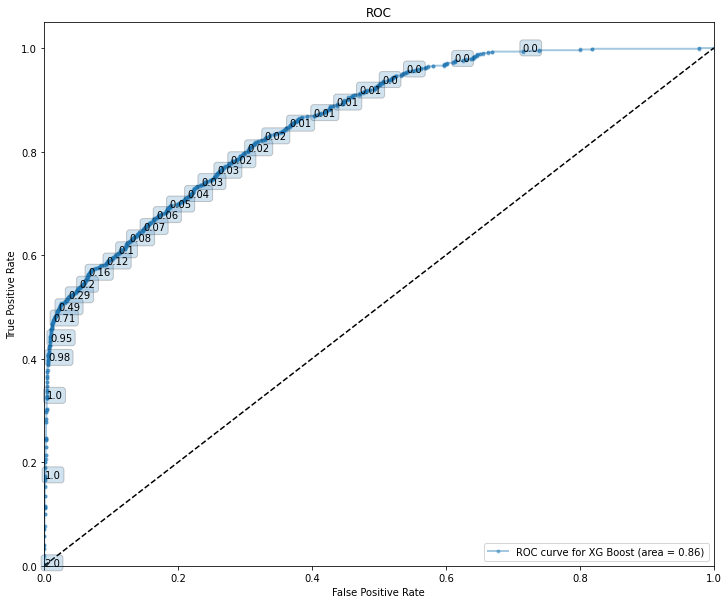

In [201]:
fig, ax = plt.subplots(figsize=(12,10))
make_roc('XG Boost',xgb_best_upselling,y_val_upselling.values,X_val_scaled_upselling,ax=ax,labe=20,initial=True)

From the plot, we can see that the ROC AUC score for XGBoost Model is 0.86

Best Threshold=0.035802, G-Mean=0.753



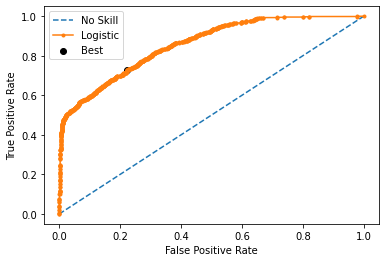

The best threshold for XGBoost Model is:  0.035802342


In [202]:
best_threshold_xgb_upselling = get_best_threshold(xgb_best_upselling, X_val_scaled_upselling, y_val_upselling.values)
print("The best threshold for XGBoost Model is: ", best_threshold_xgb_upselling)

Now, let's repredict whether the customer will churn or not, based on the best threshold obtained.

In [203]:
y_pred_val_xgb_upselling = repredict(xgb_best_upselling, best_threshold_xgb_upselling, X_val_scaled_upselling)

In [204]:
fscore_rf = f1_score(y_pred_val_xgb_upselling,y_val_upselling.values)
print("fscore for XGBoost model with the best threshold={:.2f}".format(fscore_rf))

fscore for XGBoost model with the best threshold=0.32


### Modeling for Appetency

#### Training the best model with GridSearchCV

In [207]:
xgb_appetency = xgb.XGBClassifier()
# param_grid_xgb_appetency = { "n_estimators": [300,350,400,450,500,1000], "max_depth": [3,4,5,6,7,8,9], "learning_rate":[0.03,0.01,0.1]}
best_params_xgb_appetency = {'learning_rate': [0.1], 'max_depth': [8], 'n_estimators': [800]}

In [206]:
# xgb_best_appetency, _ = do_classify(xgb_appetency, best_params_xgb_appetency, X_balanced_scaled_appetency, y_balanced_appetency, X_val_scaled_appetency, y_val_appetency.values, X_balanced_scaled_appetency.columns, score_func='roc_auc')


SCORE FUNC roc_auc
BEST {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 800} 0.9736173156519932
############# based on standard predict 0.5 ################
ROC AUC score on training data: 1.00
ROC AUC precision score on validation data:     0.90
[[8926  340]
 [ 605  129]]
########################################################


#### Saving the best model

In [210]:
filename_xgb_appetency = '/content/drive/MyDrive/UnivAI/ML-2 project/model/xgb_best_appetency'
# pickle.dump(xgb_best_appetency, open(filename_xgb_appetency, 'wb'))
xgb_best_appetency = pickle.load(open(filename_xgb_appetency,'rb'))

In [211]:
print("Best XGBoost model is : ",xgb_best_appetency)

Best XGBoost model is :  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, n_estimators=800, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


#### Predicting appetency

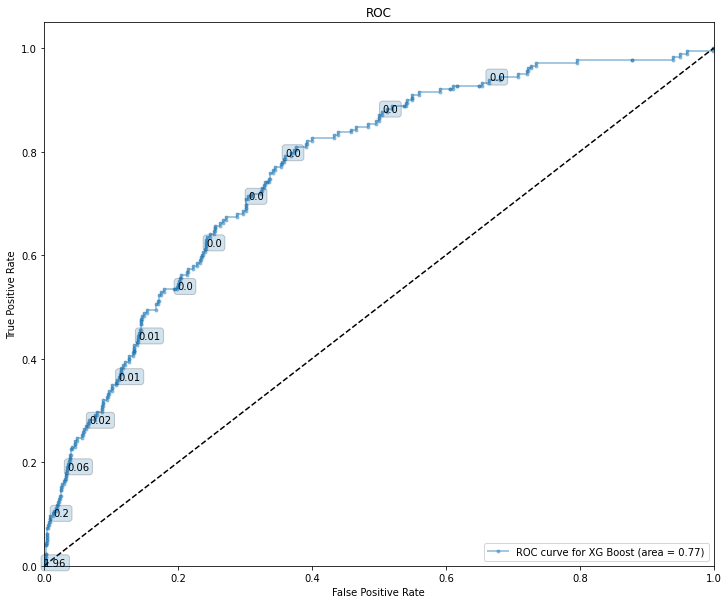

In [212]:
fig, ax = plt.subplots(figsize=(12,10))
make_roc('XG Boost',xgb_best_appetency,y_val_appetency.values,X_val_scaled_appetency,ax=ax,labe=20,initial=True)

From the plot, we can see that the ROC AUC score for XGBoost is 0.77

Best Threshold=0.000585, G-Mean=0.712



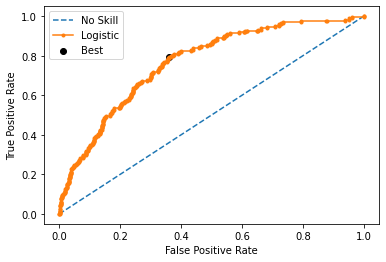

The best threshold for XGBoost is:  0.0005852155


In [213]:
best_threshold_xgb_appetency = get_best_threshold(xgb_best_appetency, X_val_scaled_appetency, y_val_appetency.values)
print("The best threshold for XGBoost is: ", best_threshold_xgb_appetency)

Now, let's repredict whether the customer will churn or not, based on the best threshold obtained.

In [214]:
y_pred_val_xgb_appetency = repredict(xgb_best_appetency, best_threshold_xgb_appetency, X_val_scaled_appetency)

In [216]:
fscore_xgb_appetency = f1_score(y_pred_val_xgb_appetency,y_val_appetency.values)
print("fscore for XGBoost with the best threshold={:.2f}".format(fscore_xgb_appetency))

fscore for XGBoost with the best threshold=0.07


## Results from all the Models

In [81]:
model_comparison = PrettyTable()
model_comparison.field_names = ["Method", "Churn AUC score","Upselling AUC score","Appetency AUC score"]
model_comparison.add_row(["Baseline Model", 0.5, 0.5, 0.5])
model_comparison.add_row(["Logistic Regression", 0.64, 0.77, 0.78])
model_comparison.add_row(["Random Forest", 0.72, 0.87, 0.82])
model_comparison.add_row(["Gradient Boosting", 0.71, 0.86, 0.71])
model_comparison.add_row(["Random Forest", 0.70, 0.86, 0.77])

print(model_comparison)

+---------------------+-----------------+---------------------+---------------------+
|        Method       | Churn AUC score | Upselling AUC score | Appetency AUC score |
+---------------------+-----------------+---------------------+---------------------+
|    Baseline Model   |       0.5       |         0.5         |         0.5         |
| Logistic Regression |       0.64      |         0.77        |         0.78        |
|    Random Forest    |       0.72      |         0.87        |         0.82        |
|  Gradient Boosting  |       0.71      |         0.86        |         0.71        |
|    Random Forest    |       0.7       |         0.86        |         0.77        |
+---------------------+-----------------+---------------------+---------------------+


***From the above table, we can say that Random Forest is the best model for predicting Churn, Upselling and Appetency for the customers.***

## Interpretation

#### Permutance Importance

In [68]:
def plot_permute_importance(result1,X,y):
    plt.xkcd(scale=0.3,randomness=0.6)

    fig, (ax1) = plt.subplots(1, 1, figsize=(14, 14))

    tree_importance_sorted_idx = np.argsort(result1.importances_mean)
    tree_indices = np.arange(0, len(result1.importances_mean)) +0.5

    ax1.barh(tree_indices, result1.importances_mean[tree_importance_sorted_idx], 
              height=0.7, color='#B2D7D0')
    ax1.set_yticks(tree_indices)
    ax1.set_yticklabels(X.columns[tree_importance_sorted_idx], fontsize=12)
    ax1.set_ylim((0, len(result1.importances_mean)))
    ax1.set_xlabel("Permutation Feature Importance", fontsize=16) 

    plt.show()

In [69]:
rf_permute_importance_train = permutation_importance(rf,X_balanced_scaled,y_balanced, random_state=66)

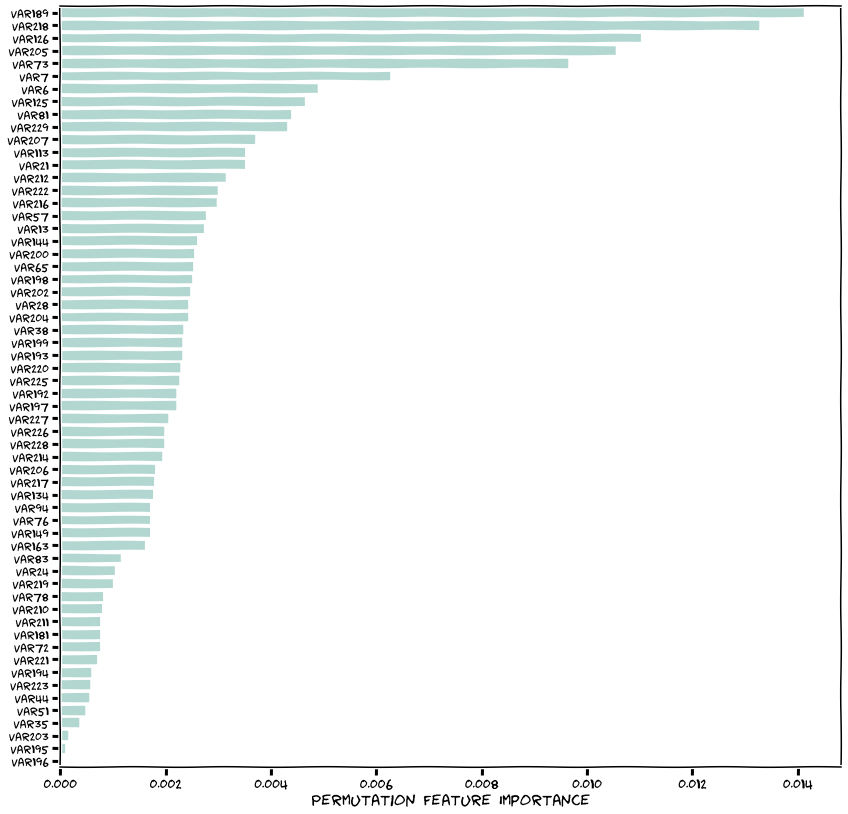

In [70]:
plot_permute_importance(rf_permute_importance_train,X_balanced_scaled,y_balanced)

In [71]:
# On test set
rf_permute_importance_val = permutation_importance(rf,X_val_scaled,y_val, random_state=66)

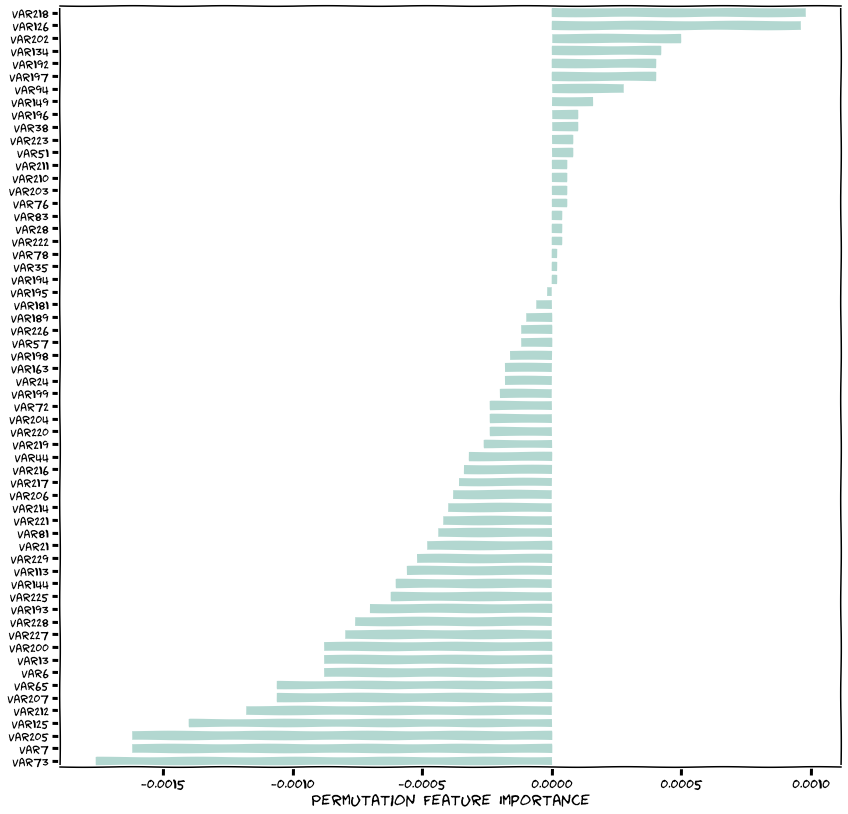

In [72]:
plot_permute_importance(rf_permute_importance_val,X_balanced_scaled,y_balanced)

#### Feature Importance

In [74]:

def plot_feature_importance(model1,X,y):
    
    plt.xkcd(scale=0.3,randomness=0.6)

    fig, (ax1) = plt.subplots(1, 1, figsize=(14, 14))


    tree_importance_sorted_idx = np.argsort(model1.feature_importances_)
    tree_indices = np.arange(0, len(model1.feature_importances_)) + 0.5

    ax1.barh(tree_indices, 
           model1.feature_importances_[tree_importance_sorted_idx], 
           height=0.7, color='#B2D7D0')
    ax1.set_yticks(tree_indices)
    ax1.set_yticklabels(X.columns[tree_importance_sorted_idx], 
                        fontsize=12)
    ax1.set_ylim((0, len(model1.feature_importances_)))

    ax1.set_xlabel("Impurity Based Feature Importance", fontsize=16)
    

    fig.tight_layout()
    plt.show()

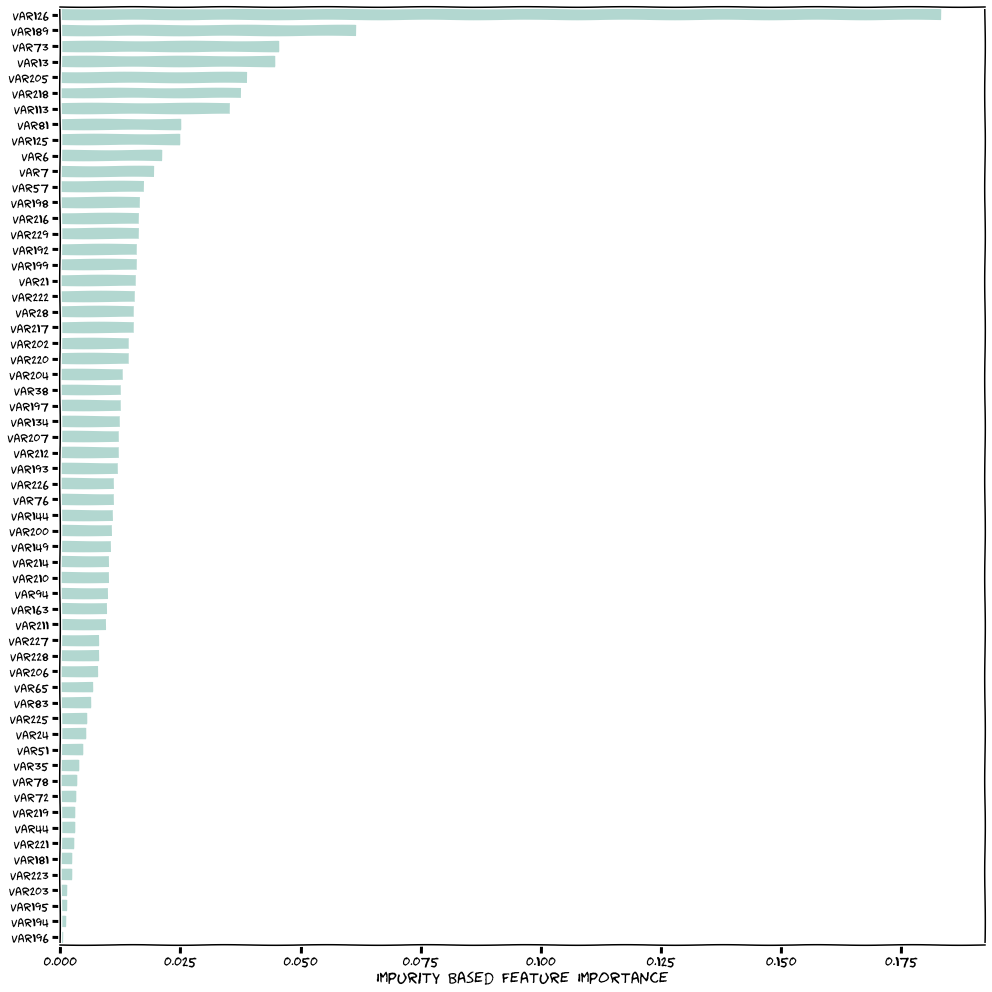

In [75]:
plot_feature_importance(rf,X_balanced_scaled,y_balanced)

### Partial Dependence

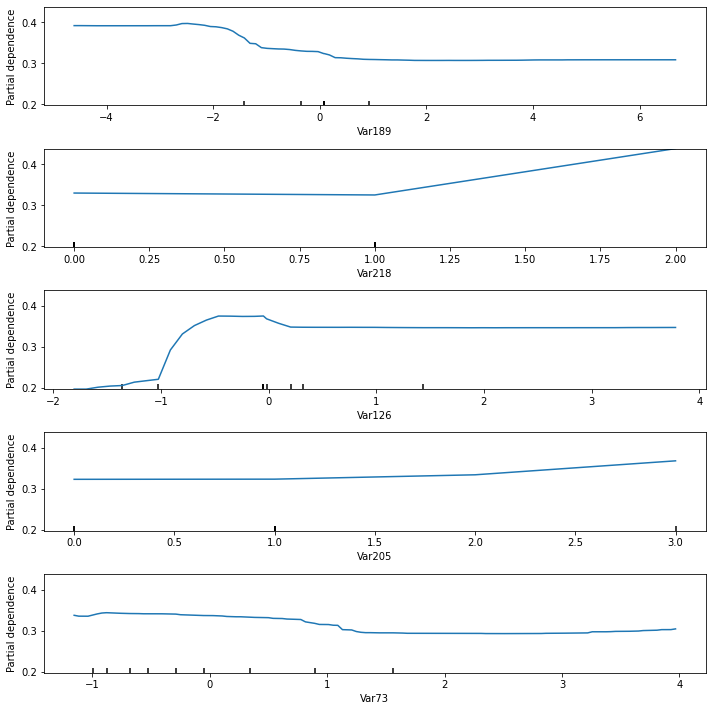

In [85]:
fig, axes = plt.subplots(5, 1, figsize = (10, 10))
#Consider the top 5 important features and graph the partial distribution plot
features=['Var189', 'Var218','Var126','Var205','Var73']
plot_partial_dependence(rf,X_balanced_scaled, features,grid_resolution=200,ax = axes)
fig.tight_layout()

# Conclusion